In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scm_module import *

In [49]:
def get_best_estimated_matching_error(intv_args_dict,gm):
    '''
    '''
    mean_list=gm.means_
    cov_list = gm.covariances_

    comp_perm_list = it.permutations(intv_args_dict.keys())
    min_err = float("inf")
    min_perm=None
    for comp_perm in comp_perm_list:
        err = 0.0
        for cidx,comp in enumerate(comp_perm):
            mean_err = np.sum(
                np.abs(mean_list[cidx]-intv_args_dict[comp]["true_params"]["mui"])
            )
            cov_error = np.sum(
                np.abs(cov_list[cidx]-intv_args_dict[comp]["true_params"]["Si"])
            )
            err+=mean_err+cov_error
        #Now checking if this perm/matching gives minimum error
        if err<min_err:
            min_err=err 
            min_perm=comp_perm
    print("error:",min_err)
    print("min_perm:",min_perm)
    return min_err,min_perm


def sample_expt_runner(gSCM,num_samples,num_nodes,new_noise_mean,debug=False):
    #Genetaing the samples from each of the mixture
    intv_args_dict={}
    mixture_samples=[]
    for nidx in range(num_nodes):
        #Creating the interv args
        intv_args=dict(
                    intv_type="do",
                    inode=nidx,
                    new_mui=new_noise_mean, #need not keep it different
        )
        #Generating the samples for this internvetions
        X,true_params = gSCM.generate_sample_with_atomic_intervention(
                                        num_samples=num_samples,
                                        intv_args=intv_args
        )
        mixture_samples.append(X)
        #Upting the true param of this dist to compare later
        intv_args["true_params"]=true_params
        intv_args_dict[str(nidx)]=intv_args
    #Adding the observational distribution
    intv_args=dict(intv_type="obs")
    Xobs,obs_true_params = gSCM.generate_sample_with_atomic_intervention(
                                        num_samples=num_samples,
                                        intv_args=intv_args
    )
    mixture_samples.append(Xobs)
    intv_args["true_params"]=obs_true_params
    intv_args_dict["obs"]=intv_args



    #Consolidating all the samples into one big pile
    mixture_samples = np.concatenate(mixture_samples,axis=0)




    #Now we are ready run the mini disentanglement algos
    gm = GaussianMixture(n_components=len(intv_args_dict),random_state=0).fit(
                                                mixture_samples
    )#None number of component not allowed!
    
    if debug:
        print("==================================")
        print("Estimated Means (unmatched):")
        pprint(gm.means_*(gm.means_>1e-5))
        print("==================================")
        pprint("Estimated Covarainces (unmatched):")
        pprint(gm.covariances_*(gm.covariances_>1e-5))
    min_err,min_perm = get_best_estimated_matching_error(intv_args_dict,gm)
    return min_err,min_perm

# Random Graph Sampling

In [71]:
def generate_random_graph(num_nodes,max_strength,num_parents):
    '''
    This function will return random graph controlling the following parameters:
    1. strength of connections
    2. sparsity of connection
    '''
    #Generating the edges with a particular strength
    A = np.tril(
            np.random.uniform(-max_strength,max_strength,size=(num_nodes,num_nodes)),-1)
    #Next we will ensure number of parents is within max limits
    for nidx in range(num_nodes):
        mask = np.array([1,]*num_parents + [0,]*(nidx-num_parents))
        np.random.shuffle(mask)
        mask_vec = np.zeros(num_nodes)
        mask_vec[0:mask.shape[0]]=mask
        A[nidx,:]=A[nidx,:]*mask_vec
    
    assert np.sum(np.diag(A))==0.0,"Diagnoal non zero"
    
    return A

# Job Runner

In [105]:
args={}
node_list = [2,4,6]
all_node_run_dict = {}
for num_nodes in node_list:
    print("========================")
    print("Num Node:",num_nodes)
    print("========================")
    max_strength=10
    num_parents=2
    run_list = [0,1,2]
    all_run_dict = {}
    for ridx in run_list:
        print("\t run_idx:",ridx)
        alpha_list=np.linspace(0,max_strength,3).tolist()
        alpha_mean_error_dict={}
        for aidx,alpha in enumerate(alpha_list):
            print("\t\t alpha:",alpha)
            args["noise_mean_list"]=[0.0,]*num_nodes
            args["noise_sigma_list"]=[1.0,]*num_nodes
            args["adj_mat"]=generate_random_graph(num_nodes=num_nodes,
                                                  max_strength=alpha,
                                                  num_parents=num_parents,
            )
            #Creating the SCM
            gSCM = GaussianSCM(args)

            new_noise_mean_list=np.linspace(0,10,3)
            sample_list=[10,20,40,100,150,200,400,800,1600,3200,6400]
            mean_error_dict={}
            for new_noise_mean in new_noise_mean_list:
                error_list = []
                for samples in sample_list:
                    print("\t\t\t sample:",samples)
                    err,_ = sample_expt_runner(gSCM,samples,num_nodes,new_noise_mean)
                    error_list.append(err)
                mean_error_dict[str(new_noise_mean)]=error_list

                #Plotting the error
            alpha_mean_error_dict["{:.2f}".format(alpha)]=mean_error_dict
        #Collecting all the runs
        all_run_dict[ridx]=alpha_mean_error_dict
    all_node_run_dict[num_nodes]=all_run_dict

#Next consolidate all the runs in single place

Generating SCM


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[-0.        ,  0.09277936],
       [ 2.20499585,  0.06971426],
       [-0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.2864012 ,  0.06135286],
        [ 0.06135286,  0.15266494]],

       [[ 0.01511459, -0.        ],
        [-0.        ,  0.00486108]],

       [[ 0.16280228,  0.03001266],
        [ 0.03001266,  0.01569383]]])
error: 7.584011130626227
min_perm: ('o

Estimated Means (unmatched):
array([[-0.        ,  0.00123484],
       [ 0.        ,  0.03503241],
       [ 0.02275173,  0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.94245063,  0.02085765],
        [ 0.02085765,  1.00044547]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.95606856]],

       [[ 0.99399659, -0.        ],
        [-0.        ,  0.        ]]])
error: 0.2148074319642292
min_perm: ('obs', '0', '1')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.]

Estimated Means (unmatched):
array([[-0.        ,  5.        ],
       [ 0.0266681 , -0.        ],
       [ 5.        ,  0.00751931]])
'Estimated Covarainces (unmatched):'
array([[[ 0.92824896, -0.        ],
        [-0.        ,  0.        ]],

       [[ 1.03566845,  0.00450987],
        [ 0.00450987,  0.96298399]],

       [[ 0.        ,  0.        ],
        [-0.        ,  0.99126011]]])
error: 0.22304046905139416
min_perm: ('1', 'obs', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([5., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.

Estimated Means (unmatched):
array([[10.        , -0.        ],
       [ 0.09270539, 10.        ],
       [-0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[0.        , 0.        ],
        [0.        , 1.09185611]],

       [[1.03682284, 0.        ],
        [0.        , 0.        ]],

       [[1.08195536, 0.01400494],
        [0.01400494, 0.96829763]]])
error: 0.4697175144635675
min_perm: ('0', '1', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([10.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
Esti

Estimated Means (unmatched):
array([[-0.00000000e+00,  3.72775046e-01],
       [ 5.44958623e-02, -0.00000000e+00],
       [ 2.11050788e-05,  8.62899266e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 1.03403897, -0.        ],
        [-0.        ,  6.17137363]],

       [[ 0.83587153,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.95084222]]])
error: 1.9926155735981534
min_perm: ('obs', '1', '0')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -2.10267936],

Estimated Means (unmatched):
array([[-0.       , -0.       ],
       [-0.       ,  0.       ],
       [-0.       ,  0.0349644]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        , -0.        ],
        [-0.        ,  1.06363664]],

       [[ 0.99289303,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 1.03230381, -0.        ],
        [-0.        ,  5.59361852]]])
error: 0.4874333689949458
min_perm: ('0', '1', 'obs')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([  5.       , -10.5133968])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -2.10267936],
       [-2.

Estimated Means (unmatched):
array([[-0.        ,  0.10168891],
       [ 5.        , -0.        ],
       [ 0.02467435,  5.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.11286036, -0.        ],
        [-0.        ,  5.47667871]],

       [[ 0.        , -0.        ],
        [-0.        ,  1.02773815]],

       [[ 1.03204703,  0.        ],
        [ 0.        ,  0.        ]]])
error: 0.6984697819972917
min_perm: ('obs', '0', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([  5.       , -10.5133968])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -2.10267936],
   

 'mui': array([ 10.        , -21.02679361])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -2.10267936],
       [-2.10267936,  5.42126049]]),
 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[10.        , -0.        ],
       [ 0.05869575, 10.        ],
       [ 0.02819173, -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.98946431]],

       [[ 0.93610034,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 1.03543979, -0.        ],
        [-0.        ,  5.97654209]]])
error: 1.1855039540466281
min_perm: ('0', '1', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 

Estimated Means (unmatched):
array([[-0.        ,  0.        ],
       [-0.        ,  0.00148065],
       [ 0.10488905,  0.9255404 ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.19640584,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  1.38312702]],

       [[ 0.72835576,  7.1082092 ],
        [ 7.1082092 , 70.22405642]]])
error: 32.94834468772823
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  9.74452331],
       [ 9.74452331, 95.

Estimated Means (unmatched):
array([[ 0.02892936,  0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.98565993, -0.        ],
        [-0.        ,  0.        ]],

       [[ 1.03448469, 10.08254705],
        [10.08254705, 99.29059429]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.97850663]]])
error: 4.39216073128681
min_perm: ('1', 'obs', '0')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  9.74452331],
       [ 9.74452331, 95.

'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  9.74452331],
       [ 9.74452331, 95.95573459]]),
 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[5.00000000e+00, 4.87840146e+01],
       [5.56622433e-03, 5.00000000e+00],
       [8.78773905e-02, 8.63246506e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ],
        [ 0.        ,  1.0299668 ]],

       [[ 1.00944796,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 1.00902577,  9.83967346],
        [ 9.83967346, 97.00051289]]])
error: 2.301609286066785
min_perm: ('0', '1', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([ 5.        , 48.72261656])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True p

Estimated Means (unmatched):
array([[-0.        , 10.        ],
       [10.        , 97.45867625],
       [-0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.01131732, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.93195354]],

       [[ 0.9423858 ,  9.17012489],
        [ 9.17012489, 90.20056085]]])
error: 8.475894022130374
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([10.        , 97.44523312])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  9.74452331],
 

Estimated Means (unmatched):
array([[-0.        , -0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.06529899]])
'Estimated Covarainces (unmatched):'
array([[[ 0.93953353,  0.10338385],
        [ 0.10338385,  1.00843456]],

       [[ 0.73320339, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.        , -0.        ],
        [-0.        ,  1.23854003]]])
error: 1.0257645681846785
min_perm: ('obs', '1', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])

Estimated Means (unmatched):
array([[-0.        , -0.        ],
       [ 0.03807373,  5.        ],
       [ 5.        ,  0.03118329]])
'Estimated Covarainces (unmatched):'
array([[[0.98065596, 0.04386429],
        [0.04386429, 1.10209427]],

       [[1.04607548, 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 1.02549631]]])
error: 0.4219566603397359
min_perm: ('obs', '1', '0')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([5., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
Estimated

       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[-0.00000000e+00,  1.00000000e+01],
       [ 1.00000000e+01, -0.00000000e+00],
       [ 2.46755689e-04,  1.08461021e-02]])
'Estimated Covarainces (unmatched):'
array([[[1.04697141, 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.9681405 ]],

       [[1.02379586, 0.00457212],
        [0.00457212, 1.01859879]]])
error: 0.17414100418576223
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([10.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'

Estimated Means (unmatched):
array([[ 0.02382835,  0.        ],
       [-0.        ,  0.2682386 ],
       [-0.        ,  0.07095783]])
'Estimated Covarainces (unmatched):'
array([[[ 0.95214126, -0.        ],
        [-0.        ,  0.        ]],

       [[ 1.04469837, -0.        ],
        [-0.        , 10.92261994]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  1.20418212]]])
error: 2.473066178791286
min_perm: ('1', 'obs', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1.42139536e-33, 3.77013973e-17],
       [3.77013973e-17, 1.00000000e+00]]),
 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1

Estimated Means (unmatched):
array([[ 0.01742274, -0.        ],
       [ 5.        , -0.        ],
       [ 0.03394654,  5.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.97773006, -0.        ],
        [-0.        ,  9.04326339]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.99073136]],

       [[ 1.07086621,  0.        ],
        [ 0.        ,  0.        ]]])
error: 1.1636473404097878
min_perm: ('obs', '0', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1.42139536e-33, 3.77013973e-17],
       [3.77013973e-17, 1.00000000e+00]]),
 'mui': array([  5.        , -14.72389758])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True para

Estimated Means (unmatched):
array([[ 9.46933120e-03, -0.00000000e+00],
       [ 1.00000000e+01, -0.00000000e+00],
       [ 3.22815408e-02,  1.00000000e+01]])
'Estimated Covarainces (unmatched):'
array([[[ 1.04939958, -0.        ],
        [-0.        ,  9.8646173 ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  1.02370464]],

       [[ 0.96025605,  0.        ],
        [ 0.        ,  0.        ]]])
error: 0.6493853125511447
min_perm: ('obs', '0', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1.42139536e-33, 3.77013973e-17],
       [3.77013973e-17, 1.00000000e+00]]),
 'mui': array([ 10.        , -29.44779516])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'i

Estimated Means (unmatched):
array([[ 0.12958294,  0.        ],
       [ 0.18120347, -0.        ],
       [-0.        ,  2.11934213]])
'Estimated Covarainces (unmatched):'
array([[[ 0.85105311, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.51193033, -0.        ],
        [-0.        , 31.43531676]],

       [[ 0.42911032, -0.        ],
        [-0.        , 25.46529875]]])
error: 74.31813906542479
min_perm: ('1', 'obs', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -7.78445138],
       [-7.78445138, 61.

error: 1.7832131067290071
min_perm: ('0', '1', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([  5.        , -38.92225689])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -7.78445138],
       [-7.78445138, 61.59768324]]),
 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[ 0.02219679, -0.        ],
       [ 5.        , -0.        ],
       [-0.        ,  5.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.93730315, -0.        ],
        [-0.        , 56.84098731]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.98561312]],

       [[ 0.94

Estimated Means (unmatched):
array([[-0.        , 10.        ],
       [10.        , -0.        ],
       [-0.        ,  0.09028583]])
'Estimated Covarainces (unmatched):'
array([[[ 1.03848399, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  1.03070564]],

       [[ 1.01768085, -0.        ],
        [-0.        , 62.56773451]]])
error: 1.4598122637781892
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([ 10.        , -77.84451377])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -7.78445138

Estimated Means (unmatched):
array([[-0.        ,  0.        ],
       [ 0.04019895, -0.        ],
       [-0.        ,  0.02109961]])
'Estimated Covarainces (unmatched):'
array([[[ 0.94837839,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 1.02273196, -0.        ],
        [-0.        ,  1.00470532]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.92378269]]])
error: 0.3628740491593474
min_perm: ('1', 'obs', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])

Estimated Means (unmatched):
array([[-0.00000000e+00,  5.00000000e+00],
       [ 5.00000000e+00, -0.00000000e+00],
       [ 1.07105115e-04,  1.52512442e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 1.02237197, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.        , -0.        ],
        [-0.        ,  1.00424383]],

       [[ 1.012755  ,  0.02634925],
        [ 0.02634925,  1.00714639]]])
error: 0.1523033497718252
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([5., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]

error: 0.5607983028127609
min_perm: ('0', '1', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([10.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[ 4.10303834e-02,  9.97127567e-03],
       [ 1.00000000e+01, -0.00000000e+00],
       [-0.00000000e+00,  1.00000000e+01]])
'Estimated Covarainces (unmatched):'
array([[[0.992582  , 0.06681527],
        [0.06681527, 1.0239412 ]],

       [[0.        , 0.        ],
        [0.        , 1.04360479]],

       [[1.10092663, 0.        ],
        [0.     

Estimated Means (unmatched):
array([[-0.00000000e+00,  4.02658055e-05],
       [ 0.00000000e+00,  6.37668479e-03],
       [-0.00000000e+00,  1.59958219e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.90292709,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        , -0.        ],
        [-0.        ,  0.7778088 ]],

       [[ 1.02581439, -0.        ],
        [-0.        ,  2.63289616]]])
error: 1.0012071865555998
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -1.18821738],

        [-0.        ,  0.        ]]])
error: 0.3228899067310556
min_perm: ('obs', '0', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([ 5.        , -5.94108689])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -1.18821738],
       [-1.18821738,  2.41186054]]),
 'mui': array([0., 0.])}
Estimated Means (unmatched):
array([[ 0.01942898,  5.        ],
       [ 5.        , -0.        ],
       [-0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.01883935, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.        , -0.        ],
        [-0.   

Estimated Means (unmatched):
array([[-0.        , 10.        ],
       [10.        , -0.        ],
       [-0.        ,  0.01036895]])
'Estimated Covarainces (unmatched):'
array([[[ 0.95096771, -0.        ],
        [-0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.97384295]],

       [[ 1.00208561, -0.        ],
        [-0.        ,  2.38700961]]])
error: 0.19665673182671528
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([ 10.        , -11.88217379])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        , -1.1882173

Estimated Means (unmatched):
array([[ 0.01072002, -0.        ],
       [-0.        , -0.        ],
       [-0.        ,  0.0220844 ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.05530337,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.96480412,  8.37888394],
        [ 8.37888394, 73.69630961]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.8766922 ]]])
error: 4.041893237879511
min_perm: ('1', 'obs', '0')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  8.70144474],
       [ 8.70144474, 76.

Estimated Means (unmatched):
array([[2.42499283e-02, 1.79772934e-01],
       [5.00000000e+00, 4.35152611e+01],
       [9.21715859e-03, 5.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.06611362,  9.29356771],
        [ 9.29356771, 82.06792384]],

       [[ 0.        , -0.        ],
        [-0.        ,  1.04305013]],

       [[ 1.07206054,  0.        ],
        [ 0.        ,  0.        ]]])
error: 6.9395329342722665
min_perm: ('obs', '0', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([ 5.        , 43.50722371])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,

Estimated Means (unmatched):
array([[-0.        , 10.        ],
       [10.        , 86.96526961],
       [-0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.05753828,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  1.01548349]],

       [[ 0.93116942,  8.09907175],
        [ 8.09907175, 71.36256433]]])
error: 7.513520286967844
min_perm: ('1', '0', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0.],
       [0., 1.]]),
 'mui': array([10.        , 87.01444742])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0.],
       [0., 0.]]), 'mui': array([ 0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  8.70144474],
 

 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 0.32235054, -0.        ,  0.16969995, -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.12838143,  0.18988194,  0.95721658,  0.10330175],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  0.9025

Estimated Means (unmatched):
array([[ 0.00896189,  0.13392618, -0.        ,  0.01978192],
       [-0.        , -0.        ,  0.08053692, -0.        ],
       [ 0.05269612, -0.        ,  0.05906632, -0.        ],
       [-0.        , -0.        , -0.        ,  0.04181183],
       [-0.        ,  0.04667256, -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 8.24404374e-01,  1.45054020e-02,  4.46334411e-03,
         -0.00000000e+00],
        [ 1.45054020e-02,  1.04223291e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 4.46334411e-03, -0.00000000e+00,  7.80935663e-01,
          2.82895183e-02],
        [-0.00000000e+00, -0.00000000e+00,  2.82895183e-02,
          9.87057471e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  9.53794694e-01,  6.37300044e-02,
          4.05318380e-02],
        [ 0.00000000e+00,  6.37300044e-02,  9.47531109e-01,
          2.58397086e-03],
        [-0.00000

Estimated Means (unmatched):
array([[ 0.0464931 , -0.        ,  0.03723623,  0.        ],
       [-0.        , -0.        , -0.        ,  0.03605017],
       [-0.        ,  0.        , -0.        ,  0.03574075],
       [-0.        , -0.        , -0.        ,  0.04688603],
       [-0.        ,  0.00344751,  0.04216671,  0.01004522]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00360259, -0.        , -0.        , -0.        ],
        [-0.        ,  1.02634916, -0.        ,  0.        ],
        [-0.        , -0.        ,  0.93539511, -0.        ],
        [-0.        ,  0.        , -0.        ,  0.        ]],

       [[ 1.01816111, -0.        ,  0.        ,  0.02641126],
        [-0.        ,  0.95451572, -0.        ,  0.01374724],
        [ 0.        , -0.        ,  0.        ,  0.        ],
        [ 0.02641126,  0.01374724,  0.        ,  1.00704147]],

       [[ 1.02533859,  0.        ,  0.01502686,  0.00422809],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
    

{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 0.056555  , -0.        ,  5.        ,  0.11747215],
       [-0.        ,  5.        , -0.        , -0.        ],
       [ 0.19556329, -0.        ,  0.08616589,  5.        ],
       [ 5.        , -0.        ,  0.05683899, -0.        ],
       [ 0.04926522,  0.12015357, -0.        ,  0.04436356]])
'Estimated Covarainces (unmatched):'
array([[[ 0.96996487, -0.        ,  0.        , -0.        ],
        [-0.        ,  0.92162628,  0.        ,  0.13535931],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.13535931,  0.        ,  0.90632072]],

       [[ 0.88674403,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        ,  1.02213794,  0.01344032],
        [-0.        ,  0.        ,  0.01344032,  0

          0.00000000e+00]]])
error: 2.4978839066168375
min_perm: ('0', '2', 'obs', '1', '3')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 5., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array

Estimated Means (unmatched):
array([[ 0.01962551,  5.        ,  0.0138595 , -0.        ],
       [-0.        ,  0.01614098,  5.        , -0.        ],
       [ 5.        , -0.        ,  0.02738749,  0.00849056],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.01452319, -0.        ,  0.01234027,  5.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00481336,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        , -0.        ],
        [-0.        ,  0.        ,  1.00154977,  0.01512833],
        [-0.        , -0.        ,  0.01512833,  0.96684311]],

       [[ 1.03572582,  0.00969153,  0.        , -0.        ],
        [ 0.00969153,  0.95555857, -0.        , -0.        ],
        [ 0.        , -0.        ,  0.        , -0.        ],
        [-0.        , -0.        ,  0.        ,  1.03429383]],

       [[ 0.        , -0.        ,  0.        ,  0.        ],
        [-0.        ,  1.02801107,  0.00836027, -0.        ],
    

'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0.,  0., 10.,  0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]]),
 'mui': array([ 0.,  0.,  0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[-0.        , -0.        , -0.        , -0.        ],
       [ 0.01201211,  0.07242455,  0.36452268, 10.        ],
       [10.        ,  0.30856353,  0.04972817,  0.14456762],
       [ 0.22166413, -0.        , 10.        , -0.        ],
       [ 0.26869454, 10.        , -0.        ,  0.0

       [0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0.,  0., 10.,  0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]]),
 'mui': array([ 0.,  0.,  0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 1.00000000e+01, -0.00000000e+00,  1.14522641e-03,
         4.59476817e-02],
       [ 3.38298940e-03,  1.00000000e+01, -0.00000000e+00,
         4.47848069e-02],
       [ 8.96833638e-02,  2.85631834e-02,  6.96146374e-02,
  

error: 1.4530475682011952
min_perm: ('3', '0', 'obs', '1', '2')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0.,  0., 10.,  0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0

error: 435.5495291850453
min_perm: ('0', '2', '1', 'obs', '3')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 4.73344670e-32,  2.41545514e-32, -2.17564857e-16,
        -9.78816420e-16],
       [ 2.41545514e-32,  1.00000000e+00,  4.09944878e-01,
         1.84432717e+00],
       [-2.17564857e-16,  4.09944878e-01,  1.16805480e+00,
         5.25503630e+00],
       [-9.78816420e-16,  1.84432717e+00,  5.25503630e+00,
         2.46422182e+01]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[  1.        ,   0.        ,  -1.90762067, -12.66467798],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -1.90762067,   0.        ,   4.63901662,  28.65836529],
       [-12.66467798,   0.        ,  28.65836529, 181.63474374

Estimated Means (unmatched):
array([[ 0.00942783, -0.        ,  0.        , -0.        ],
       [ 0.        , -0.        , -0.        , -0.        ],
       [ 0.0240319 , -0.        , -0.        ,  0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.01672153, -0.        , -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[  1.08475385,   0.51151117,  -0.        ,  -0.        ],
        [  0.51151117,   1.27062597,   0.        ,  -0.        ],
        [ -0.        ,   0.        ,   0.        ,   0.        ],
        [ -0.        ,  -0.        ,   0.        ,  18.88228552]],

       [[  0.        ,  -0.        ,   0.        ,  -0.        ],
        [ -0.        ,   1.16179464,   0.44713249,   1.94862114],
        [  0.        ,   0.44713249,   1.26714064,   5.70321845],
        [ -0.        ,   1.94862114,   5.70321845,  26.66251966]],

       [[  0.97012198,   0.44238845,  -0.        ,   0.        ],
        [  0.44238845,   1.347

Estimated Means (unmatched):
array([[ 0.00285183,  0.02435885, -0.        , -0.        ],
       [ 0.0345261 , -0.        , -0.        , -0.        ],
       [-0.        ,  0.00873999,  0.08752566,  0.52351871],
       [-0.        ,  0.02494905,  0.        ,  0.01235091],
       [-0.        ,  0.00792658,  0.00607388,  0.01014989]])
'Estimated Covarainces (unmatched):'
array([[[  0.98705237,   0.50101976,  -0.        ,   0.        ],
        [  0.50101976,   1.21913497,  -0.        ,   0.        ],
        [ -0.        ,  -0.        ,   4.03268102,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[  1.0355808 ,   0.        ,  -0.        ,  -0.        ],
        [  0.        ,   0.        ,  -0.        ,  -0.        ],
        [ -0.        ,  -0.        ,   4.62129692,  28.65170315],
        [ -0.        ,  -0.        ,  28.65170315, 182.39604097]],

       [[  0.99441779,   0.50672421,  -0.        ,  -0.        ],
        [  0.50672421,   1.328

Estimated Means (unmatched):
array([[ 0.0102068 ,  0.00399047, -0.        ,  0.        ],
       [ 0.02590568, -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  0.01386061],
       [-0.        ,  0.00104567, -0.        ,  0.08979609],
       [-0.        ,  0.01435329, -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[  1.01488982,   0.52253293,  -0.        ,   0.        ],
        [  0.52253293,   1.25182728,  -0.        ,   0.        ],
        [ -0.        ,  -0.        ,   4.13455292,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[  0.987356  ,  -0.        ,  -0.        ,  -0.        ],
        [ -0.        ,   0.        ,   0.        ,   0.        ],
        [ -0.        ,   0.        ,   4.58589483,  28.32267433],
        [ -0.        ,   0.        ,  28.32267433, 179.45128401]],

       [[  0.99201051,   0.46453214,  -0.        ,  -0.        ],
        [  0.46453214,   1.197

Estimated Means (unmatched):
array([[ 2.45231375e-02,  1.91611512e-01,  5.00000000e+00,
         2.23305302e+01],
       [ 5.00000000e+00,  2.49596014e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 3.58068210e-03, -0.00000000e+00,  5.25775291e-02,
         5.00000000e+00],
       [-0.00000000e+00,  2.96268060e+00,  4.93980923e+00,
         2.82236025e+01],
       [ 2.98692598e-01,  2.48239163e+00,  3.89377527e-01,
         4.60850093e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 8.44356766e-01,  4.04549965e-01,  0.00000000e+00,
         -0.00000000e+00],
        [ 4.04549965e-01,  1.07849719e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          1.49279784e+01]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  1.16206209e+00,  5.00051303e-01,
          2

error: 54.380261189002184
min_perm: ('1', '0', '2', '3', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 4.73344670e-32,  2.41545514e-32, -2.17564857e-16,
        -9.78816420e-16],
       [ 2.41545514e-32,  1.00000000e+00,  4.09944878e-01,
         1.84432717e+00],
       [-2.17564857e-16,  4.09944878e-01,  1.16805480e+00,
         5.25503630e+00],
       [-9.78816420e-16,  1.84432717e+00,  5.25503630e+00,
         2.46422182e+01]]),
 'mui': array([  5.        ,   2.52569627,  -8.5027071 , -58.66517964])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[  1.        ,   0.        ,  -1.90762067, -12.66467798],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -1.90762067,   0.        ,   4.63901662,  28.65836529],
       [-12.66467798,

Estimated Means (unmatched):
array([[-0.        ,  3.40059739,  3.12253057, 17.08717529],
       [ 5.        ,  2.52062614, -0.        , -0.        ],
       [ 0.1182162 ,  2.35048384,  0.7050482 ,  2.66963219],
       [-0.        , -0.        ,  5.        , 22.54907101],
       [-0.        , -0.        ,  0.08740047,  5.0000005 ]])
'Estimated Covarainces (unmatched):'
array([[[  0.59523671,   0.19643245,  -0.        ,  -0.        ],
        [  0.19643245,   6.09873095,   1.67301777,   6.80391426],
        [ -0.        ,   1.67301777,   2.82913021,  16.30066105],
        [ -0.        ,   6.80391426,  16.30066105, 100.27437789]],

       [[  0.        ,   0.        ,  -0.        ,  -0.        ],
        [  0.        ,   0.98196674,   0.40665063,   1.81886482],
        [ -0.        ,   0.40665063,   1.15123005,   5.14310379],
        [ -0.        ,   1.81886482,   5.14310379,  23.98611095]],

       [[  0.94545707,   0.30647979,  -0.        ,  -0.        ],
        [  0.30647979,   6.771

Estimated Means (unmatched):
array([[ 7.52475503e-02, -0.00000000e+00,  1.00000000e+01,
         4.47523853e+01],
       [ 1.00000000e+01,  5.01825208e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 5.68717983e-02,  1.45759387e-01, -0.00000000e+00,
         1.00000000e+01],
       [-0.00000000e+00,  1.00000000e+01,  4.19663322e+00,
         1.95195578e+01],
       [ 4.19731800e-02,  3.88382843e-02, -0.00000000e+00,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[  0.80881288,   0.52533625,   0.        ,  -0.        ],
        [  0.52533625,   1.28771206,   0.        ,  -0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [ -0.        ,  -0.        ,   0.        ,  15.18829261]],

       [[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   1.00530933,   0.2108752 ,   0.98223525],
        [  0.        ,   0.2108752 ,   1.11592699,   5.03340965],
        [  0.        ,   0.98223525,   5.033

Estimated Means (unmatched):
array([[ 1.00000000e+01,  5.01570982e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
         4.50283382e+01],
       [-0.00000000e+00, -0.00000000e+00,  2.25211407e-01,
         1.00000000e+01],
       [-0.00000000e+00,  1.00000000e+01,  4.23979636e+00,
         1.93530677e+01],
       [ 3.88705031e-02,  3.48050042e-02,  2.20055165e-02,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.99094571,   0.28470696,   1.22119711],
        [  0.        ,   0.28470696,   1.01562659,   4.57422247],
        [  0.        ,   1.22119711,   4.57422247,  21.42577179]],

       [[  1.00404682,   0.56344826,  -0.        ,  -0.        ],
        [  0.56344826,   1.26151456,   0.        ,  -0.        ],
        [ -0.        ,   0.        ,   0.        ,   0.        ],
        [ -0.        ,  -0.        ,   0.   

Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00,  6.81343396e-03,
         1.00000000e+01],
       [ 1.00000000e+01,  5.05298215e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 3.36076558e-02, -0.00000000e+00,  1.00000000e+01,
         4.48661262e+01],
       [ 2.30151229e-02,  8.46698947e-02, -0.00000000e+00,
        -0.00000000e+00],
       [ 1.54756252e-03,  1.00000000e+01,  4.12714105e+00,
         1.85536051e+01]])
'Estimated Covarainces (unmatched):'
array([[[  0.95584091,   0.48431673,  -0.        ,  -0.        ],
        [  0.48431673,   1.23472558,  -0.        ,  -0.        ],
        [ -0.        ,  -0.        ,   3.96499354,  -0.        ],
        [ -0.        ,  -0.        ,  -0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.98067564,   0.39751473,   1.77000877],
        [  0.        ,   0.39751473,   1.14414823,   5.12817412],
        [  0.        ,   1.77000877,   5.128

Estimated Means (unmatched):
array([[ 1.00000000e+01,  5.06460809e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 1.37015271e-02,  6.12028533e-03,  1.00000000e+01,
         4.49486032e+01],
       [-0.00000000e+00, -0.00000000e+00,  1.08646180e-02,
         1.00000005e+01],
       [-0.00000000e+00,  4.59949387e-03,  1.76072070e-02,
         1.18015811e-01],
       [ 1.48348565e-02,  1.00000000e+01,  4.06411677e+00,
         1.81980305e+01]])
'Estimated Covarainces (unmatched):'
array([[[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   1.01186387,   0.4176524 ,   1.87150341],
        [  0.        ,   0.4176524 ,   1.12694243,   5.05426915],
        [  0.        ,   1.87150341,   5.05426915,  23.63827246]],

       [[  0.99141609,   0.48934595,   0.        ,  -0.        ],
        [  0.48934595,   1.25966284,  -0.        ,  -0.        ],
        [  0.        ,  -0.        ,   0.        ,   0.        ],
        [ -0.        ,  -0.        ,   0.   

'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[  1.        ,  -1.52957611,   0.        ,   7.69976143],
       [ -1.52957611,   3.33960307,   0.        , -17.46462364],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  7.69976143, -17.46462364,   0.        ,  92.6311674 ]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.        , -1.52957611, -9.03179875,  0.        ],
       [-1.52957611,  3.33960307, 15.66209167,  0.        ],
       [-9.03179875, 15.66209167, 85.98578804,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[  1.        ,  -1.52957611,  -9.03179875,   7.69976143],
       [ -1.52957611,   3.33960307,  15.66209167, -17.46462364],
       [ -9.03179875,  15.66209167,

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.20200501, -0.        ],
       [ 0.0086857 , -0.        , -0.        ,  0.34631315],
       [ 0.13605595, -0.        , -0.        ,  5.14515796],
       [-0.        ,  0.86210503,  2.83513569, -0.        ],
       [ 0.02754224, -0.        , -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.13910737e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          1.05836806e-05],
        [-0.00000000e+00, -0.00000000e+00,  4.27865117e+01,
          7.07818117e+00],
        [-0.00000000e+00,  1.05836806e-05,  7.07818117e+00,
          2.24288497e+00]],

       [[ 8.54184216e-01, -0.00000000e+00,  0.00000000e+00,
          6.80661827e+00],
        [-0.00000000e+00,  3.03095898e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 6.80661

 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[  1.        ,  -1.52957611,  -9.03179875,   7.69976143],
       [ -1.52957611,   3.33960307,  15.66209167, -17.46462364],
       [ -9.03179875,  15.66209167,  85.98578804, -80.04857581],
       [  7.69976143, -17.46462364, -80.04857581,  92.6311674 ]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[-0.        ,  0.03352524, -0.        , -0.        ],
       [ 0.0464697 ,  0.        , -0.        , -0.        ],
       [ 0.        , -0.        , -0.        ,  0.35191631],
       [-0.        ,  0.0180449 ,  0.20141901,  0.        ],
       [-0.        ,  0.11665937,  0.52165189, -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 9.54046180e-01, -0.00000000e+00,  0.00000000e+00,
          7.23563106e+00],
        [-0.00000000e+00,  3.22117543e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+0

Estimated Means (unmatched):
array([[-0.00000000e+00,  7.29953266e-05,  4.44079290e-02,
         0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         6.34280134e-02],
       [ 5.68439269e-01, -0.00000000e+00, -0.00000000e+00,
         4.62131815e+00],
       [-0.00000000e+00,  1.05274666e+00,  3.01108847e+00,
        -0.00000000e+00],
       [ 1.07782467e-02,  0.00000000e+00, -0.00000000e+00,
         4.78180124e-03]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00670088, -0.        , -0.        ,  0.        ],
        [-0.        ,  3.26468518, 15.36242582, -0.        ],
        [-0.        , 15.36242582, 85.32699076,  0.        ],
        [ 0.        , -0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.99522781,  1.86856967, -0.        ],
        [-0.        ,  1.86856967,  4.51386232, -0.        ],
        [-0.        , -0.        , -0.        , 33.10602219]],

       [

error: 98.69074016528567
min_perm: ('2', '0', '1', 'obs', '3')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.28003044e-33,  3.57775130e-17,  6.60906586e-17,
        -2.03475751e-16],
       [ 3.57775130e-17,  1.00000000e+00,  1.84726810e+00,
        -5.68725253e+00],
       [ 6.60906586e-17,  1.84726810e+00,  4.41239945e+00,
        -1.05058802e+01],
       [-2.03475751e-16, -5.68725253e+00, -1.05058802e+01,
         3.33448413e+01]]),
 'mui': array([  5.        ,  -7.64788053, -45.15899373,  38.49880714])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  6.40200432e-36, -6.20626159e+00,
        -9.99324155e-01],
       [ 6.40200432e-36,  2.15087964e-35, -4.63775769e-18,
        -9.15104768e-35],
       [-6.20626159e+00, -4.63775769e-18,  3.95

Estimated Means (unmatched):
array([[ 5.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         3.89216938e+01],
       [-0.00000000e+00,  5.00000000e+00,  9.59597680e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  1.18598359e-01,  7.52249899e-01,
         5.00000000e+00],
       [ 1.97428363e-02, -0.00000000e+00,  5.00000000e+00,
         1.33138771e-01],
       [ 4.34852778e-03,  1.02419171e-02,  5.63712901e-03,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        , -0.        ,  0.        ],
        [ 0.        ,  1.06187939,  1.97089913, -0.        ],
        [-0.        ,  1.97089913,  4.6234591 , -0.        ],
        [ 0.        , -0.        , -0.        , 34.76241162]],

       [[ 0.95922143, -0.        , -0.        , -0.        ],
        [-0.        ,  0.        , -0.        , -0.        ],
        [-0.        , -0.        , 38.02332337,  6.80836728],
        [-0.        , -0.        ,  6.80836728,  2.3092943 ]],

       [

'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[  1.        ,  -1.52957611,  -9.03179875,   7.69976143],
       [ -1.52957611,   3.33960307,  15.66209167, -17.46462364],
       [ -9.03179875,  15.66209167,  85.98578804, -80.04857581],
       [  7.69976143, -17.46462364, -80.04857581,  92.6311674 ]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 1.48508030e-02,  2.60220849e-02, -0.00000000e+00,
         5.00000000e+00],
       [ 5.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         3.83294381e+01],
       [ 1.03968918e-02,  5.00000000e+00,  9.14782287e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  3.86770447e-02,  5.00000029e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  1.10561204e-02,  2.52938264e-01,
         1.94929872e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00706779, -0.        , -0.        ,  0.        ],
        [-0.        ,  3.35714242, 15.74532419,  0.        ],
        [-0.        

Estimated Means (unmatched):
array([[ 5.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         3.84923894e+01],
       [ 2.13798689e-02,  5.00000000e+00,  9.10567950e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         5.00000106e+00],
       [ 2.27856956e-02, -0.00000000e+00, -0.00000000e+00,
         2.77912853e-01],
       [-0.00000000e+00, -0.00000000e+00,  5.00000000e+00,
         6.73158067e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        , -0.        , -0.        ,  0.        ],
        [-0.        ,  0.95718192,  1.77892757, -0.        ],
        [-0.        ,  1.77892757,  4.31208829, -0.        ],
        [ 0.        , -0.        , -0.        , 31.88228558]],

       [[ 0.9799562 , -0.        , -0.        , -0.        ],
        [-0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        , 38.63740308,  6.0272327 ],
        [-0.        ,  0.        ,  6.0272327 ,  1.93265217]],

       [

error: 161.5586429593427
min_perm: ('2', '0', '1', 'obs', '3')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.28003044e-33,  3.57775130e-17,  6.60906586e-17,
        -2.03475751e-16],
       [ 3.57775130e-17,  1.00000000e+00,  1.84726810e+00,
        -5.68725253e+00],
       [ 6.60906586e-17,  1.84726810e+00,  4.41239945e+00,
        -1.05058802e+01],
       [-2.03475751e-16, -5.68725253e+00, -1.05058802e+01,
         3.33448413e+01]]),
 'mui': array([ 10.        , -15.29576107, -90.31798746,  76.99761428])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  6.40200432e-36, -6.20626159e+00,
        -9.99324155e-01],
       [ 6.40200432e-36,  2.15087964e-35, -4.63775769e-18,
        -9.15104768e-35],
       [-6.20626159e+00, -4.63775769e-18,  3.

Estimated Means (unmatched):
array([[ 1.00000000e+01, -0.00000000e+00, -0.00000000e+00,
         7.68870965e+01],
       [-0.00000000e+00,  1.00000000e+01,  1.86471340e+01,
        -0.00000000e+00],
       [ 1.08665114e-01, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+01],
       [-0.00000000e+00,  3.62771241e-02,  9.99999206e+00,
        -0.00000000e+00],
       [ 2.01303321e-02, -0.00000000e+00, -0.00000000e+00,
         2.18458239e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  8.37738736e-01,  1.52047332e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  1.52047332e+00,  3.85395843e+00,
         -0.00000000e+00],
        [ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          2.71933605e+01]],

       [[ 1.04965780e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0

Estimated Means (unmatched):
array([[ 2.00929201e-02, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+01],
       [ 1.00000000e+01, -0.00000000e+00, -0.00000000e+00,
         7.72456971e+01],
       [ 3.75399886e-02,  1.00000000e+01,  1.82091049e+01,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
         6.59661285e-02],
       [ 3.35014699e-02, -0.00000000e+00, -0.00000000e+00,
         2.21295451e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.99241207, -0.        , -0.        ,  0.        ],
        [-0.        ,  3.43211437, 16.00169473, -0.        ],
        [-0.        , 16.00169473, 86.5126764 , -0.        ],
        [ 0.        ,  0.        , -0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.03264514,  1.89767072, -0.        ],
        [ 0.        ,  1.89767072,  4.4390148 , -0.        ],
        [ 0.        , -0.        , -0.        , 34.4579195 ]],

       [

Estimated Means (unmatched):
array([[ 1.00000000e+01, -0.00000000e+00, -0.00000000e+00,
         7.69677758e+01],
       [-0.00000000e+00,  1.00000000e+01,  1.84977631e+01,
        -0.00000000e+00],
       [ 1.64706042e-02, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+01],
       [-0.00000000e+00,  2.07792679e-02,  1.15292378e-01,
        -0.00000000e+00],
       [ 2.97330587e-02, -0.00000000e+00,  1.00000000e+01,
         1.72504273e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.98989258,  1.84373569, -0.        ],
        [ 0.        ,  1.84373569,  4.44013611, -0.        ],
        [ 0.        , -0.        , -0.        , 33.35497042]],

       [[ 0.9662437 ,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        , -0.        ],
        [-0.        ,  0.        , 38.06395646,  6.03710368],
        [-0.        , -0.        ,  6.03710368,  1.95384283]],

       [

 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 5.84705912e-01, -0.00000000e+00, -0.00000000e+00,
         1.41835661e-01],
       [-0.00000000e+00,  1.80723009e-01, -0.00000000e+00,
        -0.00000000e+00],
       [ 2.43352917e-05,  7.44421150e-02,  7.14913588e-02,
        -0.00000000e+00],
       [-0.00000000e+00,  5.33365237e-02, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  8.75961151e-02,  4.77335964e-02,
         6.96931506e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 1.27708729e+00, -0.00000000e+00, -0.00000000e+00,
          7.68228456e-01],
        [-0.00000000e+00,  1.45960852e+00, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  3.60591127e-02,
         -0.00000000e+00],
        [ 7.68228456e-01, -0.00000000e+00, -0.00000000e+00,
          6.16225379e-01]],

       [[ 9.73118878e-01,  2.15072072e-02, -0.00000000e+00,
         -0.00000000e+00],
        [ 2.15072072e-02,  8.39869683e

{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[-0.        ,  0.02846103, -0.        , -0.        ],
       [-0.        ,  0.03435162, -0.        , -0.        ],
       [ 0.01996468, -0.        ,  0.05468659,  0.02189236],
       [-0.        ,  0.00330937,  0.        ,  0.01123866],
       [ 0.05152582, -0.        , -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.95295411, -0.        ,  0.00672149],
        [-0.        , -0.        ,  1.0075213 ,  0.00817848],
        [-0.        ,  0.00672149,  0.00817848,  0.98081455]],

       [[ 1.12412853,  0.04830764, -0.        ,  0.03701106],
        [ 0.04830764,  0.98495749, -0.        , -0.        ],
        [-0.        , -0.        ,  0.9878516 ,  0.07556686],
        [ 0.03701106, -0.        ,  0.07556686,  0

Estimated Means (unmatched):
array([[ 0.        , -0.        , -0.        ,  0.0105448 ],
       [ 0.00917974, -0.        ,  0.00058377, -0.        ],
       [ 0.01562075,  0.01242571,  0.01345994, -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.00835807,  0.00597999,  0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.96382624, -0.        , -0.        ],
        [ 0.        , -0.        ,  0.98421016, -0.        ],
        [ 0.        , -0.        , -0.        ,  1.01810958]],

       [[ 0.98131413,  0.0189404 ,  0.00955758, -0.        ],
        [ 0.0189404 ,  0.97275893, -0.        ,  0.        ],
        [ 0.00955758, -0.        ,  1.00335156, -0.        ],
        [-0.        ,  0.        , -0.        ,  0.        ]],

       [[ 0.99198074,  0.02501286, -0.        , -0.        ],
        [ 0.02501286,  0.98727331,  0.00499139, -0.        ],
    

'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 5., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]]),
 'mui': array([0., 0., 0., 5.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 0.00595429,  5.        , -0.        ,  0.06214618],
       [ 0.04

Estimated Means (unmatched):
array([[-0.00000000e+00,  5.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 2.42395267e-02, -0.00000000e+00,  5.00000000e+00,
         1.59768192e-02],
       [ 5.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         4.45764997e-03],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         3.44522409e-03],
       [ 1.99044670e-02, -0.00000000e+00,  3.43147579e-03,
         5.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00433277, -0.        ,  0.00604314, -0.        ],
        [-0.        ,  0.        , -0.        ,  0.        ],
        [ 0.00604314, -0.        ,  1.04468451, -0.        ],
        [-0.        ,  0.        , -0.        ,  0.98126475]],

       [[ 1.020106  ,  0.00692322, -0.        ,  0.00692176],
        [ 0.00692322,  0.98988559, -0.        , -0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ],
        [ 0.00692176, -0.        ,  0.        ,  1.01424921]],

       [

        [ 0.        ,  0.        ,  0.        ,  0.        ]]])
error: 4.013301326780997
min_perm: ('1', '0', 'obs', '2', '3')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0.,  0., 10.,  0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 

Estimated Means (unmatched):
array([[ 2.00365364e-02,  3.18039979e-02,  2.51599722e-02,
         1.00000000e+01],
       [ 3.56639475e-02,  1.00000000e+01,  1.27872663e-02,
        -0.00000000e+00],
       [ 3.09817146e-02, -0.00000000e+00,  1.78427195e-02,
         4.68230599e-03],
       [ 4.67046817e-03, -0.00000000e+00,  1.00000000e+01,
        -0.00000000e+00],
       [ 1.00000000e+01,  7.55468494e-03, -0.00000000e+00,
         1.24309422e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 1.01106153e+00,  4.62166840e-02, -0.00000000e+00,
          0.00000000e+00],
        [ 4.62166840e-02,  1.01213181e+00,  8.52721525e-03,
          0.00000000e+00],
        [-0.00000000e+00,  8.52721525e-03,  9.77741158e-01,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 9.54319014e-01,  0.00000000e+00, -0.00000000e+00,
          8.30680246e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0

error: 391.5172530964399
min_perm: ('2', 'obs', '0', '1', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.89000183e-35, -1.19100717e-34,  4.82660037e-34,
         4.34741513e-18],
       [-1.19100717e-34,  1.00000000e+00, -4.24574107e+00,
         4.80518285e+00],
       [ 4.82660037e-34, -4.24574107e+00,  1.90263172e+01,
        -2.04015622e+01],
       [ 4.34741513e-18,  4.80518285e+00, -2.04015622e+01,
         2.40897822e+01]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.00000000e+00, -1.19100717e-34, -3.80497503e+00,
         4.74288881e+00],
       [-1.19100717e-34,  7.50527358e-34, -3.04153973e-33,
        -2.73957544e-17],
       [-3.80497503e+00, -3.04153973e-33,  1.54778350e+01,
        -1.80465735e+01],
   

Estimated Means (unmatched):
array([[ 0.26466895, -0.        ,  3.18555048, -0.        ],
       [-0.        ,  1.01675314, -0.        ,  4.68744885],
       [-0.        ,  0.08656454, -0.        ,  0.32452451],
       [-0.        , -0.        ,  3.12158507, -0.        ],
       [-0.        , -0.        ,  0.28060024, -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 9.78060536e-01, -0.00000000e+00,  7.73794500e-01,
          8.21968080e-01],
        [-0.00000000e+00,  9.92100588e-01, -0.00000000e+00,
          8.68801337e-01],
        [ 7.73794500e-01, -0.00000000e+00,  1.70801849e+01,
         -0.00000000e+00],
        [ 8.21968080e-01,  8.68801337e-01, -0.00000000e+00,
          9.14829927e+00]],

       [[ 1.14665467e+00, -0.00000000e+00, -0.00000000e+00,
          1.65709205e+00],
        [-0.00000000e+00,  8.91413236e-01, -0.00000000e+00,
          9.17856906e-01],
        [-0.00000000e+00, -0.00000000e+00,  1.17890341e+01,
         -0.00000000e+00],
        [ 1.65709

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.18870012, -0.        ],
       [ 0.        ,  0.00319404, -0.        ,  0.02899694],
       [-0.        ,  0.02165277,  0.05942601,  0.00364382],
       [-0.        ,  0.05351792, -0.        , -0.        ],
       [ 0.02935888, -0.        ,  0.09324355,  0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.03353474e+00, -0.00000000e+00, -0.00000000e+00,
          4.95978150e+00],
        [-0.00000000e+00,  0.00000000e+00,  1.28232092e-05,
         -0.00000000e+00],
        [-0.00000000e+00,  1.28232092e-05,  1.58978874e+01,
         -0.00000000e+00],
        [ 4.95978150e+00, -0.00000000e+00, -0.00000000e+00,
          2.48377306e+01]],

       [[ 0.00000000e+00, -0.00000000e+00,  2.40678751e-05,
         -0.00000000e+00],
        [-0.00000000e+00,  1.00032732e+00, -0.00000000e+00,
          4.80465943e+00],
        [ 2.40678751e-05, -0.00000000e+00,  1.86850883e+01,
         -0.00000000e+00],
        [-0.00000

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.05090372, -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.02136134, -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.00599098, -0.        , -0.        ,  0.04100406]])
'Estimated Covarainces (unmatched):'
array([[[ 1.05328934, -0.        ,  0.12945038,  0.32628148],
        [-0.        ,  1.87479092, -0.        ,  4.3475931 ],
        [ 0.12945038, -0.        , 18.79861496, -0.        ],
        [ 0.32628148,  4.3475931 , -0.        , 23.26009349]],

       [[ 0.        ,  0.        , -0.        ,  0.        ],
        [ 0.        ,  0.99947626, -0.        ,  4.7903403 ],
        [-0.        , -0.        , 18.60733596, -0.        ],
        [ 0.        ,  4.7903403 , -0.        , 23.97603088]],

       [[ 1.03070246, -0.        ,  0.21834916, -0.        ],
        [-0.        ,  1.9071984 , -0.        , -0.        ],
    

Estimated Means (unmatched):
array([[ 2.65059273, -0.        ,  1.07957027, -0.        ],
       [ 0.19505286,  5.        , -0.        , 24.4693188 ],
       [-0.        ,  0.15639833,  0.47474629,  5.        ],
       [-0.        , -0.        ,  5.        , -0.        ],
       [-0.        ,  5.        , -0.        , 22.18471528]])
'Estimated Covarainces (unmatched):'
array([[[ 5.99921769, -0.        ,  0.57359042,  1.486901  ],
        [-0.        ,  6.24044197, -0.        ,  3.88687729],
        [ 0.57359042, -0.        , 18.70256378, -0.        ],
        [ 1.486901  ,  3.88687729, -0.        , 26.19689246]],

       [[ 1.5494173 ,  0.        , -0.        ,  7.32712468],
        [ 0.        ,  0.        , -0.        ,  0.        ],
        [-0.        , -0.        , 22.51295638, -0.        ],
        [ 7.32712468,  0.        , -0.        , 35.45925363]],

       [[ 1.42258309, -0.        , -0.        ,  0.        ],
        [-0.        ,  1.80652044, -0.        ,  0.        ],
    

'True params:'
{'Si': array([[  1.        ,  -0.96141732,   0.27695395,   0.12310282],
       [ -0.96141732,   1.92432326,  -4.5120094 ,   4.68682967],
       [  0.27695395,  -4.5120094 ,  19.10302074, -20.36746835],
       [  0.12310282,   4.68682967, -20.36746835,  24.10493649]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 0.54005894,  5.        , -0.        , 26.82900398],
       [-0.        , -0.        ,  5.        , -0.        ],
       [ 0.05698833, -0.        ,  0.13224304,  5.        ],
       [-0.        ,  5.        , -0.        , 21.8343421 ],
       [ 2.48867773, -0.        ,  1.08199222, -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.74536134,  0.        , -0.        ,  3.51379568],
        [ 0.        ,  0.        , -0.        ,  0.        ],
        [-0.        , -0.        , 10.28956795, -0.        ],
        [ 3.51379568,  0.        , -0.        , 17.54914861]],

       [[ 1.14725287, -0.        , -0.        ,  0.36787033],

Estimated Means (unmatched):
array([[ 2.50389774, -0.        ,  0.62321349,  0.36971868],
       [-0.        ,  5.        , -0.        , 16.27388609],
       [ 0.02866193, -0.        , -0.        ,  5.        ],
       [ 0.04368932, -0.        ,  5.00000378,  0.15438269],
       [-0.        ,  5.        , -0.        , 23.89328224]])
'Estimated Covarainces (unmatched):'
array([[[ 6.67566991, -0.        ,  2.40639895,  0.23775895],
        [-0.        ,  7.38390573, -0.        ,  4.30474863],
        [ 2.40639895, -0.        , 18.94813417, -0.        ],
        [ 0.23775895,  4.30474863, -0.        , 23.00558921]],

       [[ 0.22885874, -0.        , -0.        ,  0.44550988],
        [-0.        ,  0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  2.79408395, -0.        ],
        [ 0.44550988,  0.        , -0.        ,  1.08030211]],

       [[ 1.01104354, -0.        ,  0.44719588,  0.        ],
        [-0.        ,  2.03032576, -0.        , -0.        ],
    

Estimated Means (unmatched):
array([[ 1.13764311e-02,  5.00000000e+00, -0.00000000e+00,
         2.40975305e+01],
       [ 7.49983959e-03, -0.00000000e+00,  5.00000052e+00,
        -0.00000000e+00],
       [ 5.00000000e+00, -0.00000000e+00,  1.38741664e+00,
         6.56711513e-01],
       [ 2.85428263e-02, -0.00000000e+00,  4.14363359e-02,
        -0.00000000e+00],
       [-0.00000000e+00,  5.08329587e-02, -0.00000000e+00,
         5.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.03210082,  0.        , -0.        ,  4.88349877],
        [ 0.        ,  0.        , -0.        ,  0.        ],
        [-0.        , -0.        , 15.95093191, -0.        ],
        [ 4.88349877,  0.        , -0.        , 24.0836618 ]],

       [[ 0.96996805, -0.        ,  0.        ,  0.14445135],
        [-0.        ,  1.92171586, -0.        ,  4.82690249],
        [ 0.        , -0.        ,  0.        , -0.        ],
        [ 0.14445135,  4.82690249, -0.        , 24.96297541]],

       [

{'Si': array([[ 1.        , -0.96141732,  0.27695395,  0.        ],
       [-0.96141732,  1.92432326, -4.5120094 ,  0.        ],
       [ 0.27695395, -4.5120094 , 19.10302074,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 'mui': array([ 0.,  0.,  0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[  1.        ,  -0.96141732,   0.27695395,   0.12310282],
       [ -0.96141732,   1.92432326,  -4.5120094 ,   4.68682967],
       [  0.27695395,  -4.5120094 ,  19.10302074, -20.36746835],
       [  0.12310282,   4.68682967, -20.36746835,  24.10493649]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[-0.00000000e+00,  2.63409670e-01,  1.00000000e+01,
         1.05187008e+00],
       [ 2.10837355e-01,  1.00000000e+01, -0.00000000e+00,
         4.89837298e+01],
       [ 1.00000000e+01, -0.00000000e+00,  3.06646117e+00,
         1.10547470e+00],
       [ 2.67134332e-02,  2.93719810e-03, -0.00000000e+00,
   

Estimated Means (unmatched):
array([[-0.00000000e+00,  1.00000000e+01, -0.00000000e+00,
         4.52316311e+01],
       [-0.00000000e+00,  4.09000322e-02,  5.03832875e+00,
        -0.00000000e+00],
       [ 5.08210713e-02, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+01],
       [ 1.00000000e+01, -0.00000000e+00,  3.24608015e+00,
         6.60938335e-01],
       [ 5.76186035e-01,  1.00000000e+01, -0.00000000e+00,
         5.09397026e+01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.63132138,  0.        , -0.        ,  2.88186596],
        [-0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        , 11.68109261, -0.        ],
        [ 2.88186596,  0.        , -0.        , 14.0813403 ]],

       [[ 0.9846972 , -0.        , -0.        ,  0.39812338],
        [-0.        ,  1.87128781, -0.        ,  4.76366961],
        [-0.        , -0.        , 32.83042284, -0.        ],
        [ 0.39812338,  4.76366961, -0.        , 25.3667728 ]],

       [

Estimated Means (unmatched):
array([[ 2.89254657e-02, -0.00000000e+00,  4.08712699e-02,
        -0.00000000e+00],
       [-0.00000000e+00,  1.00000000e+01, -0.00000000e+00,
         4.80206898e+01],
       [ 7.05581089e-02, -0.00000000e+00,  2.86056703e-01,
         1.00000000e+01],
       [ 1.00000000e+01, -0.00000000e+00,  2.69759246e+00,
         1.29413268e+00],
       [ 1.66167709e-03, -0.00000000e+00,  1.00000000e+01,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.94557446, -0.        , -0.        ,  0.57475615],
        [-0.        ,  1.67132634, -0.        ,  4.24977093],
        [-0.        , -0.        , 18.58609281, -0.        ],
        [ 0.57475615,  4.24977093, -0.        , 24.19706448]],

       [[ 0.98845462,  0.        , -0.        ,  4.67879008],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        , 15.65416478, -0.        ],
        [ 4.67879008,  0.        , -0.        , 23.18551105]],

       [

'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.89000183e-35, -1.19100717e-34,  4.82660037e-34,
         4.34741513e-18],
       [-1.19100717e-34,  1.00000000e+00, -4.24574107e+00,
         4.80518285e+00],
       [ 4.82660037e-34, -4.24574107e+00,  1.90263172e+01,
        -2.04015622e+01],
       [ 4.34741513e-18,  4.80518285e+00, -2.04015622e+01,
         2.40897822e+01]]),
 'mui': array([10.        , -9.61417316,  2.76953953,  1.23102817])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.00000000e+00, -1.19100717e-34, -3.80497503e+00,
         4.74288881e+00],
       [-1.19100717e-34,  7.50527358e-34, -3.04153973e-33,
        -2.73957544e-17],
       [-3.80497503e+00, -3.04153973e-33,  1.54778350e+01,
        -1.80465735e+01],
       [ 4.74288881e+00, -2.73957544e-17, -1.80465735e+01,
         2.34949943e+01]]),
 'mui': array([  0.        ,  10.        , -42.457410

Estimated Means (unmatched):
array([[ 1.51424200e-01,  5.74330221e-01,  5.16854697e-01,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  2.53968182e+01,
         1.95330997e+00],
       [ 3.03207238e-01,  2.40529419e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 2.92809369e-02,  2.37752288e-01, -0.00000000e+00,
         2.57308502e-05],
       [-0.00000000e+00, -0.00000000e+00,  1.77681912e+00,
         1.58147523e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 1.18659209e+00,  4.48027418e+00,  3.89751957e+00,
         -0.00000000e+00],
        [ 4.48027418e+00,  3.51590172e+01, -0.00000000e+00,
         -0.00000000e+00],
        [ 3.89751957e+00, -0.00000000e+00,  2.59369252e+01,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          1.20068374e+01]],

       [[ 9.40734803e-01,  7.41303056e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 7.41303056e+00,  5.90346158e+01, -0.00000000e+00,
         -0

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.        ,  0.2160017 ],
       [-0.        , -0.        ,  0.05625682, -0.        ],
       [-0.        , -0.        ,  9.60463309,  0.3095502 ],
       [-0.        , -0.        , -0.        ,  0.07344504],
       [ 1.5465778 , 12.15726425, -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 8.67970140e-01,  6.81919516e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 6.81919516e+00,  5.44702494e+01,  0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          1.21236026e+01]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.07754283e+00, -0.00000000e+00,
          1.98399708e-02],
        [-0.00000000e+00, -0.00000000e+00,  5.78734694e+01,
         -0.00000000e+00],
        [ 0.00000

Estimated Means (unmatched):
array([[ 2.18248373e-02,  3.04654661e-02,  6.73964066e-02,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  6.25510507e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  1.13134906e-02, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  2.33361807e+01,
         1.65212995e+00],
       [ 4.10658991e-01,  3.07413376e+00, -0.00000000e+00,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.04893456e+00,  4.19986447e+00,  3.21367450e+00,
         -0.00000000e+00],
        [ 4.19986447e+00,  3.34135267e+01, -0.00000000e+00,
         -0.00000000e+00],
        [ 3.21367450e+00, -0.00000000e+00,  2.06115265e+01,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          1.13515423e+01]],

       [[ 1.01107372e+00,  7.86539485e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 7.86539485e+00,  6.22358833e+01, -0.00000000e+00,
         -0

Estimated Means (unmatched):
array([[-0.00000000e+00,  6.81299969e-02, -0.00000000e+00,
         1.37437660e-02],
       [-0.00000000e+00, -0.00000000e+00,  2.03643889e+01,
         1.55551718e+00],
       [-0.00000000e+00, -0.00000000e+00,  6.75545316e-01,
        -0.00000000e+00],
       [ 4.82449195e-01,  3.72602486e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  1.81687708e-02, -0.00000000e+00,
         3.53242188e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 1.09443617e+00,  4.27896926e+00,  3.44745928e+00,
         -0.00000000e+00],
        [ 4.27896926e+00,  3.39638103e+01,  3.65274458e-03,
         -0.00000000e+00],
        [ 3.44745928e+00,  3.65274458e-03,  2.21988706e+01,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          1.17267677e+01]],

       [[ 6.80670509e-01,  5.30345009e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 5.30345009e+00,  4.24027725e+01, -0.00000000e+00,
         -0

Estimated Means (unmatched):
array([[-0.        , -0.        ,  5.        ,  0.57245319],
       [ 5.        , 38.97659313, -0.        , -0.        ],
       [-0.        , -0.        ,  0.73410926,  5.        ],
       [-0.        , -0.        ,  0.18909797,  0.06802312],
       [ 0.08741892,  5.        , -0.        , -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 9.88532408e-01,  7.56104415e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 7.56104415e+00,  5.87562468e+01,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          1.12714128e+01]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  1.05800919e+00, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  5.53779568e+01,
          1.97443455e-01],
        [-0.00000

error: 636.6695552780061
min_perm: ('1', '0', 'obs', '2', '3')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -7.2961278 , -0.07198719],
       [ 0.        , -7.2961278 , 54.23348083,  0.5252277 ],
       [ 0.        , -0.07198719,  0.5252277 ,  1.00518215]]),
 'mui': array([   5.        ,   38.92870916, -252.39573563,  -16.99051368])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  1.32783458e-16,  6.32662028e+00,
        -2.83762910e+00],
       [ 1.32783458e-16,  1.76314468e-32,  8.40070521e-16,
        -3.76790205e-16],
       [ 6.32662028e+00,  8.40070521e-16,  4.10261242e+01,
        -1.79526018e+01],
       [-2.83762910e+00, -3.76790205e-16, -1.79526018e

error: 427.9778679845709
min_perm: ('1', '0', '3', 'obs', '2')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -7.2961278 , -0.07198719],
       [ 0.        , -7.2961278 , 54.23348083,  0.5252277 ],
       [ 0.        , -0.07198719,  0.5252277 ,  1.00518215]]),
 'mui': array([   5.        ,   38.92870916, -252.39573563,  -16.99051368])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  1.32783458e-16,  6.32662028e+00,
        -2.83762910e+00],
       [ 1.32783458e-16,  1.76314468e-32,  8.40070521e-16,
        -3.76790205e-16],
       [ 6.32662028e+00,  8.40070521e-16,  4.10261242e+01,
        -1.79526018e+01],
       [-2.83762910e+00, -3.76790205e-16, -1.79526018

Estimated Means (unmatched):
array([[ 1.03579307e-01,  5.04570048e-01,  1.00000000e+01,
        -0.00000000e+00],
       [ 1.00000000e+01,  7.76848034e+01, -0.00000000e+00,
        -0.00000000e+00],
       [ 1.15768606e-01,  1.00000000e+01, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  5.90022681e+00,
         1.00000000e+01],
       [ 4.96696214e-02,  3.23672239e-01, -0.00000000e+00,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00452115e+00,  7.82761945e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 7.82761945e+00,  6.19201737e+01,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          1.26081206e+01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.02552127e+00, -0.00000000e+00,
         -0

error: 265.9823963843435
min_perm: ('1', '0', 'obs', '3', '2')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -7.2961278 , -0.07198719],
       [ 0.        , -7.2961278 , 54.23348083,  0.5252277 ],
       [ 0.        , -0.07198719,  0.5252277 ,  1.00518215]]),
 'mui': array([  10.        ,   77.85741833, -504.79147126,  -33.98102736])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  1.32783458e-16,  6.32662028e+00,
        -2.83762910e+00],
       [ 1.32783458e-16,  1.76314468e-32,  8.40070521e-16,
        -3.76790205e-16],
       [ 6.32662028e+00,  8.40070521e-16,  4.10261242e+01,
        -1.79526018e+01],
       [-2.83762910e+00, -3.76790205e-16, -1.7952601

error: 426.9834280127922
min_perm: ('2', '0', '1', 'obs', '3')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -7.2961278 , -0.07198719],
       [ 0.        , -7.2961278 , 54.23348083,  0.5252277 ],
       [ 0.        , -0.07198719,  0.5252277 ,  1.00518215]]),
 'mui': array([  10.        ,   77.85741833, -504.79147126,  -33.98102736])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  1.32783458e-16,  6.32662028e+00,
        -2.83762910e+00],
       [ 1.32783458e-16,  1.76314468e-32,  8.40070521e-16,
        -3.76790205e-16],
       [ 6.32662028e+00,  8.40070521e-16,  4.10261242e+01,
        -1.79526018e+01],
       [-2.83762910e+00, -3.76790205e-16, -1.795260

 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 2.15595455e-02,  7.82154426e-02, -0.00000000e+00,
         0.00000000e+00],
       [-0.00000000e+00,  1.22005712e-01, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  5.76572978e-02,
         9.64054289e-02],
       [-0.00000000e+00,  0.00000000e+00,  1.01727599e-01,
         1.15202134e-01],
       [ 3.08199046e-05, -0.00000000e+00,  2.18512463e-02,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.06187575e+00, -0.00000000e+0

Estimated Means (unmatched):
array([[ 0.        , -0.        ,  0.05100382, -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.02985855, -0.        , -0.        ,  0.05799424],
       [-0.        ,  0.07295621, -0.        ,  0.05054577],
       [-0.        ,  0.        ,  0.01345728,  0.0157354 ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00,  9.83265617e-01, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  8.90594698e-01,
          3.03754033e-04],
        [-0.00000000e+00, -0.00000000e+00,  3.03754033e-04,
          1.01859309e+00]],

       [[ 9.38455011e-01,  8.05696706e-03, -0.00000000e+00,
         -0.00000000e+00],
        [ 8.05696706e-03,  1.08813881e+00, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  9.29997904e-01,
          0.00000000e+00],
        [-0.00000

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.01108108,  0.        ],
       [-0.        ,  0.00647207, -0.        , -0.        ],
       [-0.        , -0.        ,  0.02493226, -0.        ],
       [-0.        , -0.        , -0.        ,  0.00718663],
       [ 0.00793868, -0.        ,  0.        ,  0.01206278]])
'Estimated Covarainces (unmatched):'
array([[[ 0.97833114, -0.        , -0.        , -0.        ],
        [-0.        ,  0.98401078, -0.        ,  0.        ],
        [-0.        , -0.        ,  0.96130804, -0.        ],
        [-0.        ,  0.        , -0.        ,  0.        ]],

       [[ 0.9975839 , -0.        , -0.        , -0.        ],
        [-0.        ,  0.98775554, -0.        ,  0.00414715],
        [-0.        , -0.        ,  0.99816422,  0.00721455],
        [-0.        ,  0.00414715,  0.00721455,  1.02286773]],

       [[ 0.9660939 , -0.        , -0.        ,  0.03129466],
        [-0.        ,  0.        , -0.        , -0.        ],
    

error: 4.607522900764995
min_perm: ('1', '2', 'obs', '0', '3')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 5., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0.

error: 2.3184083844920886
min_perm: ('2', '1', '3', '0', 'obs')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([0., 0., 5., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [

Estimated Means (unmatched):
array([[ 5.00000000e+00,  5.30313403e-03, -0.00000000e+00,
         7.75937685e-03],
       [ 1.77541548e-02,  1.90238811e-02,  5.00000000e+00,
         1.29612259e-02],
       [-0.00000000e+00,  4.95511444e-03, -0.00000000e+00,
         2.79800861e-03],
       [-0.00000000e+00,  5.00000000e+00,  5.43503608e-03,
        -0.00000000e+00],
       [ 1.11502744e-02,  2.04359234e-02, -0.00000000e+00,
         5.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        , -0.        ,  0.        ],
        [ 0.        ,  0.98201708, -0.        , -0.        ],
        [-0.        , -0.        ,  0.99096401,  0.00652874],
        [ 0.        , -0.        ,  0.00652874,  1.02540499]],

       [[ 1.04290156, -0.        ,  0.        , -0.        ],
        [-0.        ,  1.02129166,  0.        ,  0.01252259],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.01252259,  0.        ,  1.02747809]],

       [

error: 4.81725716950316
min_perm: ('1', '2', '0', '3', 'obs')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]),
 'mui': array([ 0.,  0., 10.,  0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 

Estimated Means (unmatched):
array([[ 2.29538237e-02, -0.00000000e+00,  6.18371105e-03,
         1.00000000e+01],
       [-0.00000000e+00,  1.00000000e+01,  9.68328831e-04,
        -0.00000000e+00],
       [ 4.59725281e-02,  6.85519533e-03, -0.00000000e+00,
        -0.00000000e+00],
       [ 1.00000000e+01, -0.00000000e+00,  1.40839224e-02,
         7.48143620e-02],
       [ 7.07966307e-02,  1.43396018e-02,  1.00000000e+01,
         3.16590885e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 0.97319086,  0.01182053,  0.01541589,  0.        ],
        [ 0.01182053,  1.00515599,  0.01177951,  0.        ],
        [ 0.01541589,  0.01177951,  1.00342322,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.98105546,  0.        ,  0.01914152, -0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.01914152,  0.        ,  0.98060481, -0.        ],
        [-0.        ,  0.        , -0.        ,  1.06825357]],

       [

 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.        ,  0.82250977,  3.87234752,  0.        ],
       [ 0.82250977,  1.67652232,  2.1472001 ,  0.        ],
       [ 3.87234752,  2.1472001 , 17.07219456,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.        ,  0.82250977,  3.87234752,  6.75948946],
       [ 0.82250977,  1.67652232,  2.1472001 ,  4.44981556],
       [ 3.87234752,  2.1472001 , 17.07219456, 28.39648494],
       [ 6.75948946,  4.44981556, 28.39648494, 49.06638491]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[ 6.97776397e-02,  7.13839314e-02,  4.06481014e-01,
        -0.00000000e+00],
       [-0.00000000e+00,  2.76892296e-03, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  3.73622012e-05, -0.

Estimated Means (unmatched):
array([[ 0.8626776 ,  0.63018738,  1.78956132,  1.15504796],
       [-0.        ,  0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  0.01820291,  0.02340409,  0.10273907],
       [ 0.01061789, -0.        ,  0.06626885,  0.1684899 ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.4966972 ,  0.46612448,  0.90847693,  0.64915231],
        [ 0.46612448,  1.37574327,  0.32382436,  0.64177564],
        [ 0.90847693,  0.32382436,  7.23653894, -0.        ],
        [ 0.64915231,  0.64177564, -0.        ,  3.57840781]],

       [[ 0.98078549, -0.        ,  4.6292216 ,  7.5214213 ],
        [-0.        ,  0.        , -0.        , -0.        ],
        [ 4.6292216 , -0.        , 22.87660317, 36.68794183],
        [ 7.5214213 , -0.        , 36.68794183, 60.03393033]],

       [[ 0.49790709,  0.47806621,  0.74188246,  0.76345231],
        [ 0.47806621,  1.27848782,  0.36286791,  0.62171429],
    

Estimated Means (unmatched):
array([[ 0.        , -0.        ,  0.0016895 , -0.        ],
       [ 0.00539721,  0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.56869862,  0.33920229,  1.15811586,  0.70258917]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00],
        [-0.00000000e+00,  1.03693427e+00, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  2.13140792e+00,
          2.32722777e+00],
        [ 0.00000000e+00, -0.00000000e+00,  2.32722777e+00,
          3.51335556e+00]],

       [[ 1.01778197e+00,  0.00000000e+00,  4.78649714e+00,
          7.78914805e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.18540580e-05,
          1.46527249e-05],
        [ 4.78649714e+00,  1.18540580e-05,  2.35065771e+01,
          3.76744271e+01],
        [ 7.78914

Estimated Means (unmatched):
array([[ 0.03811242,  0.06455581,  5.        ,  5.45132653],
       [ 5.        ,  4.06883853, 19.41969589, 33.86969172],
       [-0.        , -0.        , -0.        , -0.        ],
       [ 0.19696048,  5.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  5.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.16667527,  0.89709665,  0.        ,  3.1749884 ],
        [ 0.89709665,  1.60629118,  0.        ,  2.32937336],
        [ 0.        ,  0.        ,  0.        , -0.        ],
        [ 3.1749884 ,  2.32937336, -0.        ,  9.52348452]],

       [[ 0.        ,  0.        ,  0.        , -0.        ],
        [ 0.        ,  0.83611006, -0.        , -0.        ],
        [ 0.        , -0.        ,  1.9532211 ,  1.96390615],
        [-0.        , -0.        ,  1.96390615,  2.94861351]],

       [[ 0.89842159,  0.72543365,  3.57311797,  6.31157763],
        [ 0.72543365,  1.74188021,  1.6968099 ,  3.98400609],
    

Estimated Means (unmatched):
array([[ 5.00000000e+00,  4.12894762e+00,  1.93705442e+01,
         3.37648663e+01],
       [ 2.61465885e-03,  6.03697476e-02,  4.20130613e-03,
        -0.00000000e+00],
       [-0.00000000e+00,  5.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  5.00000000e+00,
         5.33633874e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         5.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        , -0.        ,  0.        ,  0.        ],
        [-0.        ,  0.94102903, -0.        , -0.        ],
        [ 0.        , -0.        ,  2.02317964,  2.08213266],
        [ 0.        , -0.        ,  2.08213266,  2.99822812]],

       [[ 0.95931907,  0.82731911,  3.70548926,  6.52330828],
        [ 0.82731911,  1.64435608,  2.22652339,  4.5346117 ],
        [ 3.70548926,  2.22652339, 16.20816818, 27.31224335],
        [ 6.52330828,  4.5346117 , 27.31224335, 47.68988928]],

       [

Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 5.00000000e+00,  4.11223149e+00,  1.93335582e+01,
         3.37856521e+01],
       [-0.00000000e+00,  5.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         4.99999822e+00],
       [-0.00000000e+00,  2.47080283e-02,  5.00000056e+00,
         5.34874859e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.04811248,  0.86715792,  4.08733387,  7.10093797],
        [ 0.86715792,  1.76209891,  2.27851311,  4.72717779],
        [ 4.08733387,  2.27851311, 18.10243165, 29.98726309],
        [ 7.10093797,  4.72717779, 29.98726309, 51.50009875]],

       [[ 0.        ,  0.        , -0.        ,  0.        ],
        [ 0.        ,  0.98060832, -0.        , -0.        ],
        [-0.        , -0.        ,  1.96504421,  2.06987716],
        [ 0.        , -0.        ,  2.06987716,  3.17559923]],

       [

Estimated Means (unmatched):
array([[ 5.00000000e+00,  4.10380184e+00,  1.93530464e+01,
         3.37772527e+01],
       [-0.00000000e+00,  3.13148186e-03,  5.00000015e+00,
         5.32378009e+00],
       [-0.00000000e+00,  5.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         5.00000015e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.97257441, -0.        , -0.        ],
        [ 0.        , -0.        ,  2.02623431,  2.17183446],
        [ 0.        , -0.        ,  2.17183446,  3.34444388]],

       [[ 1.01479183,  0.85057944,  0.        ,  2.63728694],
        [ 0.85057944,  1.72240501, -0.        ,  2.21426105],
        [ 0.        , -0.        ,  0.        ,  0.        ],
        [ 2.63728694,  2.21426105,  0.        ,  7.86672658]],

       [

        [ 6.31179223,  3.22912683, 27.73777606, 47.96508039]]])
error: 20.55397082368748
min_perm: ('2', '0', '1', '3', 'obs')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 2.20747585e-33, -4.69837828e-17,  4.87618160e-17,
         5.21487353e-17],
       [-4.69837828e-17,  1.00000000e+00, -1.03784355e+00,
        -1.10993054e+00],
       [ 4.87618160e-17, -1.03784355e+00,  2.07711924e+00,
         2.22139268e+00],
       [ 5.21487353e-17, -1.10993054e+00,  2.22139268e+00,
         3.37568714e+00]]),
 'mui': array([10.        ,  8.22509766, 38.72347522, 67.59489461])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.        ,  0.        ,  4.72598398,  7.67241817],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 4.72598398,  0.        ,

Estimated Means (unmatched):
array([[ 1.00000000e+01,  8.20956254e+00,  3.87466201e+01,
         6.75701119e+01],
       [ 3.46061339e-02,  1.11363652e-01,  1.00000000e+01,
         1.07833688e+01],
       [ 2.00738929e-02, -0.00000000e+00,  9.36889544e-02,
         1.98998617e-01],
       [ 9.75270582e-02,  1.00000000e+01, -0.00000000e+00,
        -0.00000000e+00],
       [ 1.37330083e-02,  4.75240665e-02,  6.04929399e-02,
         1.00000000e+01]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.04124116, -0.        , -0.        ],
        [ 0.        , -0.        ,  2.07440628,  2.18923232],
        [ 0.        , -0.        ,  2.18923232,  3.37287482]],

       [[ 1.02726571,  0.88504014,  0.        ,  2.61622577],
        [ 0.88504014,  1.78276131,  0.        ,  2.31349523],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 2.61622577,  2.31349523,  0.        ,  7.71420523]],

       [

Estimated Means (unmatched):
array([[ 3.99936926e-03,  1.33692302e-02, -0.00000000e+00,
         1.00000000e+01],
       [ 1.00000000e+01,  8.23266850e+00,  3.87002748e+01,
         6.76040718e+01],
       [ 3.00444077e-03,  1.00000000e+01, -0.00000000e+00,
        -0.00000000e+00],
       [ 2.11582796e-02,  2.70458031e-02,  1.00000000e+01,
         1.07476480e+01],
       [ 1.44130676e-02,  6.08785655e-03,  8.41419451e-02,
         8.09657565e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 0.95102449,  0.78081252,  3.67150175,  0.        ],
        [ 0.78081252,  1.59276097,  2.02490884, -0.        ],
        [ 3.67150175,  2.02490884, 16.21365528,  0.        ],
        [ 0.        , -0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.96274288, -0.        , -0.        ],
        [ 0.        , -0.        ,  2.00810287,  2.20484942],
        [ 0.        , -0.        ,  2.20484942,  3.44817037]],

       [

Estimated Means (unmatched):
array([[ 1.00000000e+01,  8.24347849e+00,  3.87046769e+01,
         6.75665437e+01],
       [ 1.79624690e-02, -0.00000000e+00,  9.99999957e+00,
         1.07507331e+01],
       [ 1.01715889e-02,  1.00000000e+01, -0.00000000e+00,
        -0.00000000e+00],
       [ 3.89903529e-02,  3.67070878e-02,  1.51063753e-01,
         1.00000000e+01],
       [ 7.93346115e-03,  3.20517251e-02,  3.63384326e-03,
         2.98200072e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.0024333 , -0.        , -0.        ],
        [ 0.        , -0.        ,  2.08066929,  2.22885814],
        [ 0.        , -0.        ,  2.22885814,  3.37810763]],

       [[ 0.98928964,  0.82474831, -0.        ,  2.61609437],
        [ 0.82474831,  1.67427993, -0.        ,  2.19455947],
        [-0.        , -0.        ,  0.        , -0.        ],
        [ 2.61609437,  2.19455947, -0.        ,  7.93191374]],

       [

Estimated Means (unmatched):
array([[ 4.94793184e-02,  6.21784910e-02,  7.41780837e-01,
        -0.00000000e+00],
       [ 5.01327899e-05, -0.00000000e+00,  3.02308687e-01,
        -0.00000000e+00],
       [ 5.22807134e-01,  2.27865260e+00, -0.00000000e+00,
         4.81507044e+01],
       [-0.00000000e+00, -0.00000000e+00,  3.77206039e-01,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  6.39737949e+00,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 9.26149473e-01,  3.43602658e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 3.43602658e+00,  1.36701707e+01, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  1.20942534e+02,
          5.74672104e-01],
        [-0.00000000e+00, -0.00000000e+00,  5.74672104e-01,
          2.85952401e+01]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          3.99142084e-04],
        [ 0.00000000e+00,  8.61805840e-01, -0.00000000e+00,
          8

error: 6299.744242968029
min_perm: ('0', '3', 'obs', '2', '1')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 3.27631735e-32,  1.61359179e-16, -2.04596588e-16,
         9.70544950e-16],
       [ 1.61359179e-16,  1.00000000e+00, -1.77623085e+00,
         9.35981387e+00],
       [-2.04596588e-16, -1.77623085e+00,  4.15499602e+00,
        -2.32063010e+01],
       [ 9.70544950e-16,  9.35981387e+00, -2.32063010e+01,
         1.31917135e+02]]),
 'mui': array([0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  0.00000000e+00, -8.25653449e+00,
         5.43371685e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.25653449e+00,  0.00000000e+00,  6.91703618e+01,
        -4.55217816e+02],
  

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.16343391, -0.        ],
       [-0.        , -0.        ,  9.07227143, -0.        ],
       [ 0.53699797,  2.17382992, -0.        , 50.34381292],
       [-0.        , -0.        ,  0.08648748, -0.        ],
       [ 0.        , -0.        ,  0.06868895, -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.07930211e+00,  4.10491094e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 4.10491094e+00,  1.66344520e+01, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  1.20127977e+02,
          1.56859648e-02],
        [-0.00000000e+00, -0.00000000e+00,  1.56859648e-02,
          4.71719767e+01]],

       [[ 7.06388764e-01,  2.64900235e+00, -0.00000000e+00,
          6.20880710e+01],
        [ 2.64900235e+00,  1.08635981e+01, -0.00000000e+00,
          2.41634042e+02],
        [-0.00000000e+00, -0.00000000e+00,  1.56394009e+02,
         -0.00000000e+00],
        [ 6.20880

Estimated Means (unmatched):
array([[ 3.11893403e-03,  1.40922732e-02, -0.00000000e+00,
         1.66918316e-02],
       [ 0.00000000e+00,  4.21463229e-03, -0.00000000e+00,
        -0.00000000e+00],
       [ 4.84923081e-01,  1.80669464e+00, -0.00000000e+00,
         4.32458149e+01],
       [-0.00000000e+00, -0.00000000e+00,  7.31525670e+00,
        -0.00000000e+00],
       [ 4.73322545e-03, -0.00000000e+00, -0.00000000e+00,
         2.56344548e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 1.04295786e+00,  4.00015043e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 4.00015043e+00,  1.63222342e+01, -0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  1.21756058e+02,
          1.64092101e-03],
        [-0.00000000e+00, -0.00000000e+00,  1.64092101e-03,
          4.45126660e+01]],

       [[ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00,  9.53781857e-01, -0.00000000e+00,
          8

error: 5745.818320421503
min_perm: ('3', '0', '1', '2', 'obs')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 3.27631735e-32,  1.61359179e-16, -2.04596588e-16,
         9.70544950e-16],
       [ 1.61359179e-16,  1.00000000e+00, -1.77623085e+00,
         9.35981387e+00],
       [-2.04596588e-16, -1.77623085e+00,  4.15499602e+00,
        -2.32063010e+01],
       [ 9.70544950e-16,  9.35981387e+00, -2.32063010e+01,
         1.31917135e+02]]),
 'mui': array([  5.        ,  19.13494869, -75.27075859, 450.78540053])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.00000000e+00,  0.00000000e+00, -8.25653449e+00,
         5.43371685e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.25653449e+00,  0.00000000e+00,  6.91

Estimated Means (unmatched):
array([[ 5.00000000e+00,  1.91028302e+01, -0.00000000e+00,
         4.50345021e+02],
       [ 1.56549103e-02,  1.19298014e-01,  5.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00,  5.00000000e+00, -0.00000000e+00,
         4.35938115e+01],
       [-0.00000000e+00, -0.00000000e+00,  5.66126001e-01,
         5.00000000e+00],
       [ 1.59447116e-02,  1.72381061e-01, -0.00000000e+00,
         2.60987154e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  9.24422417e-01, -0.00000000e+00,
          8.66194440e+00],
        [-0.00000000e+00, -0.00000000e+00,  3.90345235e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  8.66194440e+00, -0.00000000e+00,
          1.23497436e+02]],

       [[ 9.36802146e-01,  3.49109594e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 3.49109594e+00,  1.40311835e+01,  0.00000000e+00,
         -0

Estimated Means (unmatched):
array([[-0.00000000e+00,  1.51776661e-02,  9.57359138e-03,
         5.00000000e+00],
       [ 5.00000000e+00,  1.91563735e+01, -0.00000000e+00,
         4.50897590e+02],
       [-0.00000000e+00,  4.99999870e+00, -0.00000000e+00,
         4.67566064e+01],
       [-0.00000000e+00, -0.00000000e+00,  5.60683702e-01,
        -0.00000000e+00],
       [ 1.17136027e-02,  5.38968640e-02,  5.00000000e+00,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.01953072e+00,  3.93145823e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 3.93145823e+00,  1.61796430e+01, -0.00000000e+00,
          0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  2.37910912e+02,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.05028633e+00, -0.00000000e+00,
          9

Estimated Means (unmatched):
array([[ 5.00000000e+00,  1.91404279e+01, -0.00000000e+00,
         4.50827746e+02],
       [ 1.60442837e-02,  5.72525389e-02,  5.00000000e+00,
        -0.00000000e+00],
       [ 4.30705522e-03,  5.00000000e+00, -0.00000000e+00,
         4.70064540e+01],
       [ 1.81189669e-03,  8.44270078e-03, -0.00000000e+00,
         5.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  3.38303921e-01,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  9.94047115e-01, -0.00000000e+00,
          9.25927860e+00],
        [-0.00000000e+00, -0.00000000e+00,  4.09620591e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  9.25927860e+00, -0.00000000e+00,
          1.30164893e+02]],

       [[ 1.00110116e+00,  3.83768985e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 3.83768985e+00,  1.57141577e+01, -0.00000000e+00,
         -0

'Generating samples for:'
{'inode': 3, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[  1.        ,   3.82698974, -15.05415172,   0.        ],
       [  3.82698974,  15.64585045, -59.38831498,   0.        ],
       [-15.05415172, -59.38831498, 230.78247996,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ]]),
 'mui': array([ 0.,  0.,  0., 10.])}
'Generating samples for:'
{'intv_type': 'obs'}
'True params:'
{'Si': array([[ 1.00000000e+00,  3.82698974e+00, -1.50541517e+01,
         9.01570801e+01],
       [ 3.82698974e+00,  1.56458505e+01, -5.93883150e+01,
         3.54390034e+02],
       [-1.50541517e+01, -5.93883150e+01,  2.30782480e+02,
        -1.38044466e+03],
       [ 9.01570801e+01,  3.54390034e+02, -1.38044466e+03,
         8.26021623e+03]]),
 'mui': array([0., 0., 0., 0.])}
Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
        -0.00000000e+00],
       [ 1.00000000e+01,  3.83118663e+01, -0.0

Estimated Means (unmatched):
array([[-0.00000000e+00,  1.00000000e+01, -0.00000000e+00,
         9.07241087e+01],
       [ 1.00000000e+01,  3.82570192e+01, -0.00000000e+00,
         9.00718402e+02],
       [ 1.34030822e-01,  4.00050958e-01, -0.00000000e+00,
         1.00000000e+01],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
        -0.00000000e+00],
       [ 4.42057206e-03, -0.00000000e+00,  7.09086575e-02,
        -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.08913960e+00,  0.00000000e+00, -0.00000000e+00,
          5.90062304e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  7.46074364e+01,
         -0.00000000e+00],
        [ 5.90062304e+01,  0.00000000e+00, -0.00000000e+00,
          3.23419328e+03]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.18263457e+00, -0.00000000e+00,
          1

Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
        -0.00000000e+00],
       [ 1.00000000e+01,  3.82610745e+01, -0.00000000e+00,
         9.01469061e+02],
       [ 3.22130996e-02,  1.06799553e-01, -0.00000000e+00,
         2.87332798e+00],
       [ 4.36353104e-02,  1.98006105e-01, -0.00000000e+00,
         1.00000000e+01],
       [-0.00000000e+00,  1.00000000e+01, -0.00000000e+00,
         9.22476232e+01]])
'Estimated Covarainces (unmatched):'
array([[[ 9.64522996e-01,  3.75255992e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 3.75255992e+00,  1.55826363e+01,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          8.61301592e+01]],

       [[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  9.76511718e-01, -0.00000000e+00,
          8

Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00,  7.04539593e-01,
        -0.00000000e+00],
       [ 1.00000000e+01,  3.82663458e+01, -0.00000000e+00,
         9.01535277e+02],
       [ 1.72348956e-02,  6.05778495e-02,  1.00000002e+01,
        -0.00000000e+00],
       [ 7.76778670e-04,  1.00000000e+01, -0.00000000e+00,
         9.37759558e+01],
       [-0.00000000e+00,  1.43703901e-02, -0.00000000e+00,
         1.00000000e+01]])
'Estimated Covarainces (unmatched):'
array([[[ 9.57037049e-01,  3.67151654e+00, -0.00000000e+00,
          8.65579496e+01],
        [ 3.67151654e+00,  1.50801630e+01, -0.00000000e+00,
          3.41264796e+02],
        [-0.00000000e+00, -0.00000000e+00,  2.22269325e+02,
         -0.00000000e+00],
        [ 8.65579496e+01,  3.41264796e+02, -0.00000000e+00,
          7.95627583e+03]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00],
        [ 0.00000000e+00,  9.63414262e-01, -0.00000000e+00,
          8

error: 68.73595050775381
min_perm: ('5', 'obs', '2', '3', '4', '1', '0')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 

error: 61.660712882911646
min_perm: ('5', '4', '2', 'obs', '0', '3', '1')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 51.475853620781756
min_perm: ('1', '3', 'obs', '2', '0', '5', '4')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

/Users/adityakumarsinha/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Estimated Means (unmatched):
array([[ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         7.16201613e-02, -0.00000000e+00,  4.37493269e-02],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.08250872e-01, -0.00000000e+00, -0.00000000e+00],
       [ 4.91936564e-02, -0.00000000e+00,  0.00000000e+00,
         2.51079876e-01, -0.00000000e+00, -0.00000000e+00],
       [ 1.58540020e-01,  3.20706027e-02,  2.10079216e-01,
        -0.00000000e+00, -0.00000000e+00,  1.03378215e-02],
       [ 1.96265369e-01, -0.00000000e+00,  1.00991093e-02,
         2.13158883e-02,  1.29159523e-05, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  9.47512197e-02],
       [ 1.23277965e-01, -0.00000000e+00,  4.71208515e-02,
         2.55566421e-02,  5.81518273e-02,  2.19294463e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+0

Estimated Means (unmatched):
array([[ 1.09248236e-01, -0.00000000e+00, -0.00000000e+00,
         8.48596898e-02, -0.00000000e+00, -0.00000000e+00],
       [ 2.20727075e-05,  2.96940323e-02,  1.14642539e-01,
        -0.00000000e+00, -0.00000000e+00,  4.03915492e-02],
       [ 3.37095989e-02, -0.00000000e+00,  3.94075269e-03,
        -0.00000000e+00,  1.08440841e-03,  5.44021546e-02],
       [-0.00000000e+00,  4.43389992e-03,  8.27384235e-02,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  4.49784294e-02, -0.00000000e+00,
         2.84624012e-02,  2.41614502e-02,  1.09792827e-01],
       [ 1.52451204e-01,  9.55373380e-03,  2.43469380e-02,
         1.08332791e-01, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  1.65977174e-01,  1.98304116e-01,
        -0.00000000e+00,  1.21382137e+00, -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.07310134e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+0

Estimated Means (unmatched):
array([[ 0.02806716,  0.01391238,  0.03172952,  0.10854768, -0.        ,
         0.00038581],
       [ 0.00144377, -0.        ,  0.0048737 ,  0.08571342,  0.        ,
         0.03983917],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        ],
       [ 0.03093945,  0.07878442,  0.07186515,  0.        ,  0.02881462,
         0.0532508 ],
       [-0.        , -0.        ,  0.04356552,  0.03875557, -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  0.02973061,
        -0.        ],
       [ 0.04647619,  0.        , -0.        , -0.        ,  0.02252731,
         0.04722618]])
'Estimated Covarainces (unmatched):'
array([[[ 9.38520631e-01,  2.76273857e-02, -0.00000000e+00,
          6.19996749e-02, -0.00000000e+00, -0.00000000e+00],
        [ 2.76273857e-02,  1.01127536e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, 

Estimated Means (unmatched):
array([[-0.00000000e+00,  5.35798267e-02,  2.52276710e-02,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  1.61787172e-03,
         1.16427993e-03, -0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00,  7.99706578e-03,
        -0.00000000e+00, -0.00000000e+00,  3.46751035e-02],
       [-0.00000000e+00,  1.08666908e-02, -0.00000000e+00,
         8.76859502e-02,  1.70478564e-02, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         2.41086384e-02, -0.00000000e+00,  3.15809054e-02],
       [ 2.03345204e-02,  1.24583146e-02,  1.93942696e-02,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  8.05649411e-02,
         5.28614421e-02,  1.17563853e-05,  2.02805913e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 9.83660740e-01, -0.00000000e+00,  5.56577656e-03,
         -0.00000000e+00,  1.28980563e-0

Estimated Means (unmatched):
array([[ 0.        ,  0.03201422, -0.        , -0.        ,  0.00113221,
         0.00780213],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        ,  0.04400346, -0.        , -0.        , -0.        ,
        -0.        ],
       [ 0.02447427, -0.        , -0.        ,  0.03638028, -0.        ,
        -0.        ],
       [-0.        ,  0.01679272, -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.02271164],
       [-0.        , -0.        ,  0.0188015 , -0.        ,  0.03000744,
        -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00,  9.61207657e-01, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00,  1.44758096e-02],
        [ 0.00000000e+00, 

Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        ],
       [ 0.00178737,  0.00964112,  0.00471045, -0.        , -0.        ,
         0.        ],
       [-0.        ,  0.00071849,  0.00192202, -0.        ,  0.00358504,
         0.00355978],
       [ 0.02102037, -0.        , -0.        ,  0.04840874,  0.01190525,
         0.02154836],
       [-0.        ,  0.00377528, -0.        ,  0.00040923,  0.02607775,
         0.00018314],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [ 0.00388455,  0.01516037,  0.00205754,  0.00089881,  0.        ,
        -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 1.03021462e+00,  2.84097311e-02,  0.00000000e+00,
          1.60363216e-02, -0.00000000e+00, -0.00000000e+00],
        [ 2.84097311e-02,  9.66692057e-01,  0.00000000e+00,
         -0.00000000e+00,  3.02371632e-02, -0.00000000e+00],
        [ 0.00000000e+00, 

Estimated Means (unmatched):
array([[ 0.28623918, -0.        , -0.        , -0.        ,  0.28482669,
         0.32294444],
       [ 0.18271062,  0.87926651, -0.        , -0.        ,  0.02226605,
         0.01444991],
       [ 0.00286792, -0.        , -0.        ,  0.9455247 ,  0.01377799,
         0.08799202],
       [-0.        , -0.        , -0.        , -0.        ,  0.15142341,
         0.03906628],
       [ 0.11688993, -0.        ,  0.84837782,  0.00424824,  0.05850305,
         0.02808096],
       [ 0.0139374 ,  0.03147096, -0.        , -0.        ,  0.10904148,
        -0.        ],
       [ 0.0413265 , -0.        ,  0.00414983, -0.        , -0.        ,
         0.09958127]])
'Estimated Covarainces (unmatched):'
array([[[ 0.94244873,  0.05159417,  0.07980433,  0.08468685,
         -0.        , -0.        ],
        [ 0.05159417,  1.03156679, -0.        , -0.        ,
          0.07668543,  0.11308496],
        [ 0.07980433, -0.        ,  0.96614342, -0.        ,
          0.0

error: 52.51821402806513
min_perm: ('5', '4', 'obs', '2', '1', '0', '3')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 

error: 29.792209505762084
min_perm: ('5', '1', 'obs', '3', '4', '2', '0')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 16.61668770454942
min_perm: ('1', '3', 'obs', '2', '5', '4', '0')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

error: 13.650934855997907
min_perm: ('1', '2', 'obs', '3', '4', '5', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 6.907333061913715
min_perm: ('2', '3', 'obs', '5', '0', '1', '4')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 4.4553575265910546
min_perm: ('3', '1', '5', '2', '4', 'obs', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0

error: 3.518740561543769
min_perm: ('1', '2', 'obs', '3', '5', '0', '4')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 2.4634562499363057
min_perm: ('obs', '2', '1', '3', '5', '0', '4')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 46.89307732415126
min_perm: ('1', 'obs', '4', '5', '2', '3', '0')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.

error: 19.225528531947027
min_perm: ('2', '3', 'obs', '1', '5', '4', '0')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

error: 16.042593456772384
min_perm: ('1', '2', 'obs', '4', '5', '0', '3')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

error: 9.353844837720732
min_perm: ('5', '2', 'obs', '3', '4', '1', '0')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 5.050616780687947
min_perm: ('3', '2', 'obs', '1', '5', '0', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

Estimated Means (unmatched):
array([[-0.00000000e+00,  3.79947865e-02,  9.82839350e-03,
        -0.00000000e+00,  1.14644658e-02, -0.00000000e+00],
       [ 1.10367213e-03,  1.00000000e+01,  8.11509453e-04,
        -0.00000000e+00, -0.00000000e+00,  5.81647639e-04],
       [ 9.60689381e-03, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  5.27394995e-03,  1.00000000e+01],
       [ 2.17813949e-02, -0.00000000e+00,  1.00000000e+01,
         2.71824649e-02,  1.54382194e-02, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  2.30275180e-03,
        -0.00000000e+00,  1.00000000e+01, -0.00000000e+00],
       [ 1.00000000e+01, -0.00000000e+00,  1.81008141e-02,
         2.47623606e-03,  2.76661050e-02,  7.86317860e-03],
       [ 1.19079692e-02,  8.02545771e-03,  6.23166262e-03,
         1.00000000e+01,  7.23209229e-03, -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00613449e+00,  2.70690475e-03, -0.00000000e+00,
         -0.00000000e+00,  5.52238158e-0

error: 13355.77773147614
min_perm: ('0', '1', '2', '3', '5', 'obs', '4')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 'm

error: 13233.984349753528
min_perm: ('1', 'obs', '2', '0', '4', '5', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 6519.973024440952
min_perm: ('0', '2', 'obs', '4', '3', '5', '1')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 4663.455860961349
min_perm: ('2', '0', 'obs', '5', '3', '4', '1')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 6512.98662389351
min_perm: ('1', '3', '5', '4', '2', '0', 'obs')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 'm

error: 2920.938138384966
min_perm: ('0', '2', '3', '4', 'obs', '5', '1')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 5901.399146393628
min_perm: ('0', '2', 'obs', '3', '5', '4', '1')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 8570.343856987827
min_perm: ('4', '1', '0', '2', 'obs', '5', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 4089.604172488456
min_perm: ('5', '3', '0', '4', 'obs', '2', '1')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 8120.92977290683
min_perm: ('1', '0', '3', '4', 'obs', '5', '2')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 112.84954025953645
min_perm: ('obs', '5', '3', '2', '4', '0', '1')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 13190.431311929053
min_perm: ('4', '2', '5', '3', 'obs', '1', '0')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 11189.802098904942
min_perm: ('obs', '0', '5', '2', '1', '3', '4')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 5271.911462743232
min_perm: ('obs', '0', '1', '5', '3', '4', '2')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 1022.8753695396175
min_perm: ('5', '0', '3', '1', '2', 'obs', '4')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 4520.435143587294
min_perm: ('1', '0', '4', '3', '5', 'obs', '2')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 1497.005049971737
min_perm: ('1', '0', 'obs', '3', '4', '5', '2')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 827.8756866124136
min_perm: ('5', '0', '2', '4', 'obs', '1', '3')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 '

error: 3630.8882508677652
min_perm: ('5', '0', '1', '3', '2', '4', 'obs')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),


error: 4522.613649706012
min_perm: ('3', '0', '2', 'obs', '5', '1', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 3541.7870963425266
min_perm: ('1', '2', '4', 'obs', '5', '3', '0')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),


error: 218.15900732084094
min_perm: ('5', '0', '1', 'obs', '4', '3', '2')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 13499.720115984273
min_perm: ('5', '0', '1', '4', '3', '2', 'obs')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 12378.570599965402
min_perm: ('1', '0', '4', '3', '5', '2', 'obs')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 3875.4089877857086
min_perm: ('obs', '0', '1', '3', '4', '2', '5')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),


error: 4642.583874124027
min_perm: ('4', '0', '1', '5', '2', 'obs', '3')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 374.0216151600699
min_perm: ('1', '0', '5', '3', '2', 'obs', '4')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 4310.224815758743
min_perm: ('1', '0', '3', '5', '2', 'obs', '4')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 5840.796227361207
min_perm: ('5', '0', 'obs', '1', '4', '3', '2')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),
 

error: 398.29907723600815
min_perm: ('obs', '0', '2', '5', '4', '1', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),

error: 4871.853305989343
min_perm: ('obs', '0', '1', '2', '3', '5', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),


error: 348.13221714372776
min_perm: ('1', '0', '2', '5', '3', 'obs', '4')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.34182108e-34, -5.57402211e-34,  1.15837001e-17,
         0.00000000e+00,  2.18140610e-17,  2.54297567e-33],
       [-5.57402211e-34,  1.00000000e+00,  1.48222286e+00,
        -3.11072251e+00,  7.40571394e+00, -1.57750198e+00],
       [ 1.15837001e-17,  1.48222286e+00,  3.19698460e+00,
        -4.61078401e+00,  1.28600871e+01, -2.33820949e+00],
       [ 0.00000000e+00, -3.11072251e+00, -4.61078401e+00,
         1.06765946e+01, -2.30371211e+01,  4.59304718e+00],
       [ 2.18140610e-17,  7.40571394e+00,  1.28600871e+01,
        -2.30371211e+01,  5.93909232e+01, -1.16825284e+01],
       [ 2.54297567e-33, -1.57750198e+00, -2.33820949e+00,
         4.59304718e+00, -1.16825284e+01,  3.58718623e+00]]),

error: 182.26863262755205
min_perm: ('obs', '0', '1', '4', '2', '3', '5')
Generating SCM


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.2692

error: 60997.493210643996
min_perm: ('5', '0', '2', '4', '3', '1', 'obs')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 47431.622258039686
min_perm: ('1', 'obs', '2', '5', '3', '0', '4')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 54400.19077358036
min_perm: ('5', '2', '1', '4', '3', 'obs', '0')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 26257.162474083223
min_perm: ('1', '0', '4', 'obs', '2', '5', '3')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 22247.62012216228
min_perm: ('1', '3', '4', '0', 'obs', '2', '5')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 23126.4771279081
min_perm: ('5', '3', 'obs', '2', '0', '4', '1')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 'm

error: 14606.379694597848
min_perm: ('1', '2', 'obs', '0', '3', '4', '5')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 2032.712914686415
min_perm: ('4', '1', '0', 'obs', '2', '3', '5')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 18141.52074765754
min_perm: ('0', '3', '4', '2', 'obs', '5', '1')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 21147.306863599762
min_perm: ('1', '3', '4', '0', '2', '5', 'obs')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),


error: 15500.906168302668
min_perm: ('0', '4', '2', 'obs', '3', '5', '1')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 65237.49586567871
min_perm: ('5', '0', '2', 'obs', '1', '4', '3')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 'm

error: 59788.34912855392
min_perm: ('4', '0', '5', 'obs', '1', '2', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 'm

error: 22910.52277677621
min_perm: ('5', '0', 'obs', '3', '2', '4', '1')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 9796.045931643652
min_perm: ('2', '0', '4', '3', 'obs', '5', '1')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 4259.578334710716
min_perm: ('1', '0', '3', 'obs', '5', '2', '4')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 19581.530367950727
min_perm: ('1', '0', '5', 'obs', '4', '2', '3')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 4159.999235278017
min_perm: ('5', '0', '3', '2', '4', '1', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 19711.766927493863
min_perm: ('5', '0', '2', 'obs', '1', '4', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),


error: 22973.67951879582
min_perm: ('3', '0', 'obs', '4', '5', '1', '2')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 20592.34313553076
min_perm: ('1', '0', '5', '2', '4', '3', 'obs')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 20768.917671207455
min_perm: ('obs', '2', '0', '3', '4', '5', '1')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 66390.62764987945
min_perm: ('2', '0', '1', '4', 'obs', '5', '3')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 60563.04334240152
min_perm: ('2', '0', '5', '1', '4', 'obs', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 '

error: 27001.63500514264
min_perm: ('5', '0', '1', '2', '4', '3', 'obs')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

          3.27200041e+01,  3.32342309e+01,  1.17414729e+01]]])
error: 11624.519347427367
min_perm: ('5', '0', 'obs', '2', '4', '3', '1')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,

error: 22450.101873803746
min_perm: ('4', '0', 'obs', '3', '5', '2', '1')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),


error: 3721.5950996779156
min_perm: ('1', '0', '2', '4', 'obs', '5', '3')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),


error: 20537.96194122154
min_perm: ('4', '0', '1', '5', '3', 'obs', '2')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),
 

error: 2907.441390325208
min_perm: ('5', '0', '1', 'obs', '2', '4', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),


error: 21995.939563857817
min_perm: ('obs', '0', '2', '4', '5', '3', '1')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),

error: 366.26764243573456
min_perm: ('1', '0', '5', '4', 'obs', '3', '2')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.61172062e-34, -1.42715374e-33,  2.81893529e-33,
         8.45680588e-33,  1.26953559e-17,  1.05619883e-32],
       [-1.42715374e-33,  1.00000000e+00, -2.26211487e+00,
        -6.51787919e+00, -3.08191097e+00, -7.85446387e+00],
       [ 2.81893529e-33, -2.26211487e+00,  6.11716366e+00,
         1.47441914e+01,  6.97163661e+00,  1.77676995e+01],
       [ 8.45680588e-33, -6.51787919e+00,  1.47441914e+01,
         4.34827491e+01,  2.00875233e+01,  5.11944466e+01],
       [ 1.26953559e-17, -3.08191097e+00,  6.97163661e+00,
         2.00875233e+01,  1.04981752e+01,  2.42067583e+01],
       [ 1.05619883e-32, -7.85446387e+00,  1.77676995e+01,
         5.11944466e+01,  2.42067583e+01,  6.26926027e+01]]),

error: 21759.117080136144
min_perm: ('5', '0', '4', '3', 'obs', '1', '2')
Generating SCM


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 71.98291232316215
min_perm: ('4', '3', '1', '5', '2', 'obs', '0')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 

error: 59.44235906298326
min_perm: ('5', '3', '2', 'obs', '4', '1', '0')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

/Users/adityakumarsinha/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Estimated Means (unmatched):
array([[-0.        , -0.        ,  0.02710595, -0.        ,  0.04091569,
        -0.        ],
       [ 0.36274156, -0.        , -0.        ,  0.31649248, -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.04163844],
       [-0.        ,  0.08681132, -0.        ,  0.04165928,  0.0837133 ,
        -0.        ],
       [-0.        ,  0.04171026,  0.81548782, -0.        ,  0.2977774 ,
        -0.        ],
       [ 0.04725877,  0.00359711,  0.03161925,  0.09703301, -0.        ,
        -0.        ],
       [ 0.17639317,  0.00642742, -0.        , -0.        ,  0.4961121 ,
         0.81468201]])
'Estimated Covarainces (unmatched):'
array([[[ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          2.00921248e-05,  1.29465308e-05,  1.88509820e-05],
        [-0.00000000e+00,  1.00752522e+00,  1.33758037e-02,
          9.43868624e-02,  2.77490225e-02,  9.04602018e-02],
        [-0.00000000e+00, 

/Users/adityakumarsinha/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Estimated Means (unmatched):
array([[ 0.1601983 , -0.        , -0.        ,  0.16318771,  0.01553572,
         0.10222546],
       [ 0.07118395, -0.        ,  0.00414825,  0.00050865, -0.        ,
        -0.        ],
       [ 0.00130936,  0.08423771, -0.        , -0.        ,  0.01089044,
         0.20518003],
       [-0.        , -0.        ,  0.08532324, -0.        , -0.        ,
        -0.        ],
       [-0.        ,  0.08730975, -0.        , -0.        , -0.        ,
         0.11825107],
       [ 0.1452745 ,  0.19510733, -0.        , -0.        ,  0.02163621,
         0.05621511],
       [ 0.02774651,  0.11056631,  0.02385411,  0.24721603,  0.24296303,
        -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 9.75962224e-01, -0.00000000e+00, -0.00000000e+00,
          6.04391163e-02,  1.33913812e-02, -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, 

Estimated Means (unmatched):
array([[-0.        ,  0.06036954, -0.        ,  0.01935444,  0.07804637,
         0.01648344],
       [-0.        , -0.        ,  0.        ,  0.0147809 ,  0.04934845,
         0.02493804],
       [-0.        , -0.        , -0.        , -0.        ,  0.09291221,
        -0.        ],
       [-0.        ,  0.02681976,  0.01519922, -0.        , -0.        ,
        -0.        ],
       [ 0.0312117 , -0.        ,  0.01119771,  0.        ,  0.09132689,
        -0.        ],
       [ 0.02824454,  0.03670993,  0.01832107,  0.01796297, -0.        ,
        -0.        ],
       [-0.        , -0.        ,  0.00242684,  0.03660482,  0.05466931,
        -0.        ]])
'Estimated Covarainces (unmatched):'
array([[[ 9.71929689e-01,  1.34173220e-02, -0.00000000e+00,
         -0.00000000e+00,  7.26529013e-03, -0.00000000e+00],
        [ 1.34173220e-02,  1.02404255e+00,  3.35633511e-02,
          4.92275389e-02,  9.24353357e-03, -0.00000000e+00],
        [-0.00000000e+00, 

Estimated Means (unmatched):
array([[ 0.51004855,  0.0871906 , -0.        ,  0.448019  , -0.        ,
         0.30878121],
       [-0.        ,  0.41570405, -0.        ,  0.11739114, -0.        ,
        -0.        ],
       [ 0.11160019, -0.        ,  0.96960177,  0.00248716, -0.        ,
         0.08064383],
       [-0.        ,  0.08126836, -0.        , -0.        ,  0.83813586,
         0.04385421],
       [-0.        , -0.        , -0.        ,  0.13690133, -0.        ,
         0.02441919],
       [ 0.20376335,  0.22588414, -0.        , -0.        , -0.        ,
         0.16002378],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.06716701]])
'Estimated Covarainces (unmatched):'
array([[[ 0.98735201, -0.        , -0.        , -0.        ,
         -0.        , -0.        ],
        [-0.        ,  0.63988502, -0.        ,  0.034505  ,
          0.00316674,  0.02050659],
        [-0.        , -0.        ,  0.45165781,  0.01328061,
          0.0

error: 4.598439433978284
min_perm: ('3', 'obs', '4', '2', '1', '0', '5')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 3.616379465850147
min_perm: ('obs', '5', '4', '2', '3', '1', '0')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 2.3669817383768805
min_perm: ('1', '5', '4', '3', '2', '0', 'obs')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

error: 47.986540069043116
min_perm: ('1', 'obs', '4', '5', '3', '0', '2')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

error: 30.149302341616536
min_perm: ('5', '1', 'obs', '3', '2', '0', '4')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 14.71523895850141
min_perm: ('1', '2', '5', '3', '4', '0', 'obs')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

error: 9.592359304953279
min_perm: ('5', '1', 'obs', '2', '3', '0', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

error: 6.259369200722608
min_perm: ('2', 'obs', '0', '5', '3', '1', '4')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 4.6175816792532975
min_perm: ('3', '1', '2', '4', 'obs', '5', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0

error: 3.2276810740513646
min_perm: ('1', '2', 'obs', '3', '4', '5', '0')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0

error: 2.3499150347923212
min_perm: ('0', '2', '5', 'obs', '3', '1', '4')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 38.275660788021284
min_perm: ('1', 'obs', '4', '5', '0', '3', '2')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 18.911334061406293
min_perm: ('2', '1', 'obs', '3', '4', '0', '5')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

error: 13.457081229962537
min_perm: ('1', '2', 'obs', '3', '5', '0', '4')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

error: 9.335733779705505
min_perm: ('5', '1', 'obs', '3', '4', '2', '0')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 6.7476353374546045
min_perm: ('2', 'obs', '4', '5', '0', '3', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0.,

error: 5.260793047318086
min_perm: ('3', '1', 'obs', '4', '5', '2', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

Estimated Means (unmatched):
array([[-0.00000000e+00,  1.47725314e-02, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  1.18050708e-02],
       [-0.00000000e+00,  5.68875155e-04,  1.00000000e+01,
         1.15318630e-03,  8.34465896e-03,  7.84905872e-03],
       [-0.00000000e+00,  1.50126171e-02,  9.77004700e-03,
        -0.00000000e+00, -0.00000000e+00,  1.00000000e+01],
       [ 2.42394987e-02,  1.00000000e+01,  9.17170519e-03,
         5.33217163e-03,  1.08373545e-03,  2.66569683e-02],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  1.00000000e+01,  1.88876809e-02],
       [ 1.00000000e+01, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  2.07333018e-03],
       [ 1.67566806e-02, -0.00000000e+00,  1.46379976e-02,
         1.00000000e+01,  7.47009587e-03,  2.78728050e-02]])
'Estimated Covarainces (unmatched):'
array([[[ 9.94843688e-01, -0.00000000e+00,  1.36836575e-02,
          3.26897290e-03, -0.00000000e+0

error: 2203.6795093283163
min_perm: ('obs', '0', '5', '4', '2', '1', '3')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 2202.100231243741
min_perm: ('4', '1', '0', '5', 'obs', '2', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 'm

error: 1789.4486143136357
min_perm: ('2', '3', '0', '1', '5', '4', 'obs')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 729.967134305688
min_perm: ('4', '5', '0', '1', 'obs', '2', '3')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 'm

error: 1264.622225843675
min_perm: ('2', '1', '3', '5', '4', 'obs', '0')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 689.4211125945636
min_perm: ('2', '0', '3', '4', '5', '1', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 1351.694116425628
min_perm: ('0', '2', '3', '4', '5', 'obs', '1')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 1018.6953532746221
min_perm: ('1', '3', '5', 'obs', '0', '2', '4')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 1172.1525395206702
min_perm: ('0', '1', '2', '5', '3', 'obs', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 1095.3810791888823
min_perm: ('obs', '0', '3', '5', '4', '1', '2')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 1134.839754614119
min_perm: ('2', 'obs', '3', '1', '5', '0', '4')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 'm

error: 2101.312710121764
min_perm: ('5', '1', 'obs', '2', '3', '4', '0')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 'm

error: 1769.8955992951046
min_perm: ('3', '4', '5', '2', '0', 'obs', '1')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 966.4474714961535
min_perm: ('0', '1', 'obs', '3', '5', '2', '4')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 939.8037942685753
min_perm: ('2', '1', '4', '3', '0', '5', 'obs')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 252.23201578873432
min_perm: ('1', 'obs', '3', '5', '2', '0', '4')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 828.0290824775556
min_perm: ('1', '4', '3', '2', 'obs', '5', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 692.9655100913753
min_perm: ('obs', '1', '2', '0', '5', '4', '3')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 102.65273186628333
min_perm: ('2', '1', '0', 'obs', '5', '3', '4')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 65.28753001819088
min_perm: ('3', '1', 'obs', '2', '4', '5', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 68.24966998330142
min_perm: ('1', '4', '2', '3', 'obs', '0', '5')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 28.324418968991925
min_perm: ('obs', '1', '0', '4', '2', '3', '5')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 2095.0901624489434
min_perm: ('5', '1', '3', '2', 'obs', '0', '4')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 911.822912453487
min_perm: ('1', '4', 'obs', '5', '2', '0', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 'm

error: 913.991998415321
min_perm: ('5', '1', '4', '2', 'obs', '0', '3')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 '

error: 269.3405140515993
min_perm: ('2', '1', '5', '4', 'obs', '3', '0')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 242.89340818785757
min_perm: ('1', '3', '4', '2', '5', 'obs', '0')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 191.1812574240876
min_perm: ('1', '3', 'obs', '2', '5', '0', '4')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),
 

error: 143.40926139387975
min_perm: ('5', '1', 'obs', '2', '3', '0', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 161.25705276113166
min_perm: ('2', '1', '4', 'obs', '0', '5', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),

error: 88.03051385619332
min_perm: ('3', '1', '4', '2', 'obs', '5', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 38.75205688004548
min_perm: ('1', 'obs', '5', '2', '3', '0', '4')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.36663700e-31, -3.57732556e-16, -1.47682809e-15,
         1.40222314e-15, -3.49195136e-15,  9.26822232e-16],
       [-3.57732556e-16,  1.00000000e+00,  4.38890515e+00,
        -4.16719075e+00,  1.03035383e+01, -2.81433986e+00],
       [-1.47682809e-15,  4.38890515e+00,  2.02624884e+01,
        -1.92388879e+01,  4.73017815e+01, -1.32095565e+01],
       [ 1.40222314e-15, -4.16719075e+00, -1.92388879e+01,
         1.92669967e+01, -4.49122365e+01,  1.25422491e+01],
       [-3.49195136e-15,  1.03035383e+01,  4.73017815e+01,
        -4.49122365e+01,  1.11491503e+02, -3.07820989e+01],
       [ 9.26822232e-16, -2.81433986e+00, -1.32095565e+01,
         1.25422491e+01, -3.07820989e+01,  9.65613383e+00]]),


error: 478.94048191066673
min_perm: ('obs', '1', '4', '2', '3', '0', '5')
Generating SCM


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{

error: 75324.80084911293
min_perm: ('5', '1', '4', '0', '2', '3', 'obs')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1.

error: 70834.0004805705
min_perm: ('1', '0', '2', '5', '3', 'obs', '4')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1.0

error: 26310.815954997623
min_perm: ('2', '1', 'obs', '0', '5', '3', '4')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[

error: 28080.844874050174
min_perm: ('0', '1', '3', '4', 'obs', '5', '2')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[

error: 7097.320285915997
min_perm: ('0', '1', 'obs', '3', '5', '4', '2')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1

error: 47357.05698566846
min_perm: ('1', '2', '4', '3', '0', '5', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1

error: 21913.933201548694
min_perm: ('5', '2', '4', 'obs', '0', '3', '1')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[

error: 3744.989187283711
min_perm: ('2', '3', 'obs', '4', '1', '5', '0')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[

error: 18495.755063899196
min_perm: ('3', '2', 'obs', '0', '4', '1', '5')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([

error: 22883.964445773705
min_perm: ('1', '2', '4', '0', 'obs', '5', '3')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([

error: 35984.77996140509
min_perm: ('obs', '2', '1', '3', '0', '5', '4')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1, 

error: 68303.26791841269
min_perm: ('2', '0', '4', 'obs', '5', '3', '1')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1, 

error: 52583.4146189
min_perm: ('3', '0', '2', 'obs', '4', '1', '5')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1, 'int

error: 39781.63808402798
min_perm: ('5', '0', '3', 'obs', '4', '2', '1')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1,

error: 8376.15726399692
min_perm: ('2', '0', '4', '3', '1', 'obs', '5')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1, 

error: 7134.319517068975
min_perm: ('1', '0', '2', '4', 'obs', '5', '3')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1,

error: 19454.3728766712
min_perm: ('2', '0', '3', 'obs', '5', '1', '4')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1, 

error: 28025.863782171175
min_perm: ('5', '0', '2', '3', 'obs', '1', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1

error: 26232.58985010853
min_perm: ('2', '0', '4', '5', 'obs', '1', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1

error: 25517.273784227895
min_perm: ('2', '0', '1', '3', '4', '5', 'obs')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 

error: 40279.04093835362
min_perm: ('obs', '0', '1', '3', '4', '5', '2')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([  5.        ,  32.70305638,  52.98133316, 264.10526253,
        57.05905625, 353.26825846])}
'Generating samples for:'
{'inode': 1

error: 24167.4602051219
min_perm: ('obs', '5', '0', '4', '1', '3', '2')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1, 

error: 72017.34743634927
min_perm: ('5', '0', '3', '2', 'obs', '1', '4')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1,

error: 60765.177961449386
min_perm: ('1', '0', '4', 'obs', '2', '5', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1

error: 27598.436180010052
min_perm: ('1', '0', '4', '3', '2', '5', 'obs')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 

error: 7362.190263695742
min_perm: ('2', '0', '3', '1', '5', '4', 'obs')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1

error: 6247.185274931827
min_perm: ('obs', '0', '5', '3', '1', '2', '4')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1

error: 6827.013057905977
min_perm: ('5', '0', '2', 'obs', '3', '4', '1')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1

error: 2611.712835880654
min_perm: ('1', '0', '2', '5', 'obs', '3', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 1

error: 2875.767236452045
min_perm: ('2', '0', '3', '5', '4', '1', 'obs')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 

error: 17949.988165873365
min_perm: ('obs', '0', '2', '4', '1', '5', '3')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode':

error: 26575.92714414858
min_perm: ('1', '0', '2', '3', 'obs', '4', '5')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.36972486,  0.91933235, -1.10263553,
         2.28463179],
       [ 0.        ,  0.36972486,  1.13669647,  6.06352778,  1.86961246,
         7.0239607 ],
       [ 0.        ,  0.91933235,  6.06352778, 34.60508668, 12.02063872,
        37.46820887],
       [ 0.        , -1.10263553,  1.86961246, 12.02063872,  7.40182858,
        11.55285055],
       [ 0.        ,  2.28463179,  7.0239607 , 37.46820887, 11.55285055,
        44.40298849]]),
 'mui': array([ 10.        ,  65.40611275, 105.96266631, 528.21052506,
       114.1181125 , 706.53651691])}
'Generating samples for:'
{'inode': 

error: 25351.88451672846
min_perm: ('4', '0', '3', '5', 'obs', '2', '1')
Generating SCM


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.

error: 83.1836399979769
min_perm: ('obs', '2', '5', '1', '3', '4', '0')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 1

error: 59.10948725846571
min_perm: ('5', '2', '0', '1', 'obs', '4', '3')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

/Users/adityakumarsinha/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00,  3.46944631e-01,
        -0.00000000e+00, -0.00000000e+00,  1.16173418e-02],
       [ 2.08353531e-01,  3.07264935e-05,  4.39112730e-02,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 2.08890770e-01, -0.00000000e+00,  1.98752553e-02,
         8.75354933e-02, -0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  2.29062357e-01, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  2.26100685e-01],
       [ 8.28551507e-02, -0.00000000e+00,  8.39444187e-02,
         1.49297145e-01,  2.38351286e-01, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  5.57851453e-04,
        -0.00000000e+00,  2.78462063e-02, -0.00000000e+00],
       [-0.00000000e+00,  2.06462919e-02, -0.00000000e+00,
         1.65796147e-01,  1.59952462e-02,  3.48831861e-01]])
'Estimated Covarainces (unmatched):'
array([[[ 5.24052625e-01,  1.53452674e-02, -0.00000000e+00,
         -0.00000000e+00,  1.71769442e-0

Estimated Means (unmatched):
array([[-0.        , -0.        , -0.        ,  0.02244375, -0.        ,
         0.10154019],
       [-0.        , -0.        , -0.        ,  0.14229148,  0.        ,
        -0.        ],
       [ 0.11469615, -0.        , -0.        ,  0.        , -0.        ,
         0.05181561],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ],
       [ 0.00229073, -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        ,  0.        , -0.        ,  0.05366459, -0.        ,
        -0.        ],
       [-0.        , -0.        ,  0.00716369,  0.20762717,  0.0818284 ,
         0.03209799]])
'Estimated Covarainces (unmatched):'
array([[[ 9.52209161e-01, -0.00000000e+00,  4.46507218e-02,
         -0.00000000e+00, -0.00000000e+00,  3.49776836e-02],
        [-0.00000000e+00,  9.33468516e-01, -0.00000000e+00,
          9.09735705e-03, -0.00000000e+00, -0.00000000e+00],
        [ 4.46507218e-02, 

Estimated Means (unmatched):
array([[ 0.01356841, -0.        ,  0.13403278, -0.        ,  0.05219248,
        -0.        ],
       [-0.        ,  0.05108692, -0.        ,  0.05094735, -0.        ,
         0.06693958],
       [ 0.10812909, -0.        , -0.        , -0.        , -0.        ,
         0.        ],
       [ 0.04290997, -0.        ,  0.06494288, -0.        , -0.        ,
        -0.        ],
       [-0.        ,  0.08932486, -0.        ,  0.01545872,  0.        ,
        -0.        ],
       [ 0.        ,  0.11904883,  0.11007484, -0.        ,  0.00569827,
        -0.        ],
       [ 0.00074261, -0.        ,  0.        , -0.        , -0.        ,
         0.04544943]])
'Estimated Covarainces (unmatched):'
array([[[ 1.13349972, -0.        ,  0.21947868, -0.        ,
          0.04014616, -0.        ],
        [-0.        ,  1.06894637, -0.        , -0.        ,
         -0.        ,  0.04028606],
        [ 0.21947868, -0.        ,  0.93991999, -0.        ,
         -0. 

error: 9.133074295907708
min_perm: ('5', 'obs', '3', '2', '4', '1', '0')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.,

error: 6.954631870771889
min_perm: ('4', '0', '3', '2', '5', '1', 'obs')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 4.404252955135175
min_perm: ('5', '1', '0', '3', '4', '2', 'obs')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 3.3357517315623655
min_perm: ('4', '5', '1', '2', '0', '3', 'obs')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0

error: 2.24048365361339
min_perm: ('obs', '5', '0', '3', '1', '4', '2')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 1

error: 41.19607676304804
min_perm: ('1', 'obs', '4', '5', '3', '0', '2')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 

error: 20.073036065499164
min_perm: ('2', '3', 'obs', '1', '5', '0', '4')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 15.110266659302017
min_perm: ('1', '3', '4', '2', '5', 'obs', '0')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 13.589723806080922
min_perm: ('1', '2', '5', '3', 'obs', '4', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 6.644652222634633
min_perm: ('2', 'obs', '3', '5', '0', '1', '4')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 4.267875134688246
min_perm: ('3', '1', 'obs', '2', '4', '5', '0')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0.

error: 3.6016851356959587
min_perm: ('1', '3', '2', '4', '5', 'obs', '0')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([5., 0., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([0., 5., 0., 0., 0., 0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0

error: 2.3885730246770005
min_perm: ('obs', '1', '5', '2', '3', '0', '4')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 38.42634840459006
min_perm: ('1', 'obs', '4', '5', '2', '0', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.

error: 18.980821517614423
min_perm: ('2', '3', 'obs', '1', '4', '0', '5')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

error: 12.39558514970945
min_perm: ('1', '2', 'obs', '3', '4', '5', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0

error: 6.114781079461488
min_perm: ('2', 'obs', '1', '5', '3', '4', '0')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([10.,  0.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 1, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]),
 'mui': array([ 0., 10.,  0.,  0.,  0.,  0.])}
'Generating samples for:'
{'inode': 2, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[1., 0., 0., 0., 0., 

Estimated Means (unmatched):
array([[-0.00000000e+00,  1.00000000e+01, -0.00000000e+00,
         1.33459162e-02,  5.19152873e-03, -0.00000000e+00],
       [-0.00000000e+00,  1.13220372e-02,  3.06891860e-02,
         1.00000000e+01,  7.28717929e-03, -0.00000000e+00],
       [ 2.02959613e-02,  2.25507084e-03,  5.10679735e-03,
         2.11298258e-02, -0.00000000e+00,  9.67647557e-03],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
         5.57023690e-02, -0.00000000e+00,  2.73506177e-02],
       [ 1.38220055e-02,  4.94455170e-03, -0.00000000e+00,
        -0.00000000e+00,  1.00000000e+01,  9.60816944e-03],
       [ 1.00000000e+01,  1.11519096e-02,  2.55899846e-02,
         2.38624062e-03, -0.00000000e+00,  5.88542108e-03],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         6.17483009e-03,  3.66190929e-02,  1.00000000e+01]])
'Estimated Covarainces (unmatched):'
array([[[ 9.99035181e-01,  0.00000000e+00, -0.00000000e+00,
          5.35324133e-03, -0.00000000e+0

Estimated Means (unmatched):
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.20272109e-04, -0.00000000e+00, -0.00000000e+00],
       [ 8.84298414e-03,  1.00000000e+01, -0.00000000e+00,
         9.82379374e-03,  7.56848214e-03,  2.37539476e-02],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  1.00000000e+01,  2.43208791e-02],
       [-0.00000000e+00,  1.64983479e-02,  3.12040442e-03,
         1.00000000e+01, -0.00000000e+00,  1.12920284e-02],
       [-0.00000000e+00, -0.00000000e+00,  8.99151887e-03,
         2.54902410e-02, -0.00000000e+00,  1.00000000e+01],
       [ 1.00000000e+01, -0.00000000e+00,  6.84637816e-03,
        -0.00000000e+00, -0.00000000e+00,  1.91265822e-02],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+01,
         1.55683937e-02,  1.35718950e-02, -0.00000000e+00]])
'Estimated Covarainces (unmatched):'
array([[[ 1.00798297, -0.        ,  0.01500615,  0.01829186,
          0.03470779, -0.        ],
   

error: 28511.33937876214
min_perm: ('1', '3', '4', 'obs', '0', '5', '2')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 'm

error: 24534.345055433914
min_perm: ('0', 'obs', '1', '3', '5', '4', '2')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

          1.23511087e+01, -0.00000000e+00,  6.25537694e+01]]])
error: 22687.058095027158
min_perm: ('1', '4', '3', '5', '2', 'obs', '0')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,


error: 12487.58944349971
min_perm: ('0', '5', '3', '4', 'obs', '2', '1')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 9037.924697378307
min_perm: ('1', '3', '0', '5', '2', 'obs', '4')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 3606.550406545958
min_perm: ('obs', '2', '0', '3', '5', '4', '1')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 2464.131121204376
min_perm: ('2', 'obs', '1', '3', '0', '5', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 1035.4522880798588
min_perm: ('4', '2', '5', 'obs', '1', '0', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 9630.136864658552
min_perm: ('2', '3', '0', 'obs', '5', '4', '1')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 731.0789896321963
min_perm: ('0', '1', '3', 'obs', '5', '4', '2')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 713.6110202900709
min_perm: ('3', '5', '0', 'obs', '4', '1', '2')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 'm

error: 26673.853890793
min_perm: ('5', '0', 'obs', '2', '4', '1', '3')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 'mui

error: 20248.515335663917
min_perm: ('3', '0', '2', '5', '1', 'obs', '4')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 7314.527634286964
min_perm: ('3', '0', '2', '5', 'obs', '1', '4')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 1591.5137278259215
min_perm: ('2', '0', '5', '3', 'obs', '4', '1')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 9317.055059095152
min_perm: ('1', '0', '5', '4', '3', '2', 'obs')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 8145.033948559303
min_perm: ('2', '0', '1', '3', '4', '5', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 10070.490197200928
min_perm: ('3', '0', '1', '4', '5', '2', 'obs')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 12832.390182148696
min_perm: ('2', '0', '5', 'obs', '1', '3', '4')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 1058.2537812506616
min_perm: ('obs', '0', '4', '1', '2', '3', '5')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 12011.363382724927
min_perm: ('obs', '2', '4', '3', '1', '5', '0')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 491.33652245250823
min_perm: ('4', '0', '2', '5', '3', '1', 'obs')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 27206.793453828628
min_perm: ('1', '0', '2', '3', 'obs', '4', '5')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 22160.83514197751
min_perm: ('3', '0', '2', '1', '5', '4', 'obs')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 '

error: 13076.42033548771
min_perm: ('obs', '0', '1', '3', '4', '2', '5')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 4061.3716865685883
min_perm: ('2', '0', '5', 'obs', '1', '3', '4')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 2941.8591377599973
min_perm: ('1', '0', '2', '4', '5', 'obs', '3')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 2668.8604103364137
min_perm: ('4', '0', '3', '2', '5', 'obs', '1')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 7636.793381002518
min_perm: ('5', '0', 'obs', '2', '1', '3', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),
 

error: 1458.3282958053962
min_perm: ('2', '0', 'obs', '4', '3', '1', '5')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),

error: 696.7135820122171
min_perm: ('3', '0', '5', '2', 'obs', '1', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 647.7904471909853
min_perm: ('obs', '0', '5', '2', '1', '3', '4')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.69604159e-32, -2.50049623e-17, -1.19619045e-16,
        -3.25184755e-16,  3.05860142e-16, -1.66171087e-15],
       [-2.50049623e-17,  1.00000000e+00, -2.97166725e-01,
        -8.38027588e-01,  4.93317535e+00, -3.92752756e-01],
       [-1.19619045e-16, -2.97166725e-01,  1.08830806e+00,
         3.06909255e+00, -4.82074558e+00,  1.36853953e+01],
       [-3.25184755e-16, -8.38027588e-01,  3.06909255e+00,
         9.65502093e+00, -1.35947852e+01,  4.34051065e+01],
       [ 3.05860142e-16,  4.93317535e+00, -4.82074558e+00,
        -1.35947852e+01,  3.65907008e+01, -4.74573265e+01],
       [-1.66171087e-15, -3.92752756e-01,  1.36853953e+01,
         4.34051065e+01, -4.74573265e+01,  2.08413822e+02]]),


error: 341.7382512724141
min_perm: ('1', '0', '4', '2', 'obs', '5', '3')
Generating SCM


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151

error: 277453.1263128087
min_perm: ('3', '1', '2', '0', '5', 'obs', '4')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 'm

error: 251829.2433726439
min_perm: ('4', 'obs', '2', '3', '1', '5', '0')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 'm

error: 214832.33842294296
min_perm: ('0', '3', '4', '1', 'obs', '2', '5')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 116038.5801228168
min_perm: ('2', '0', '1', '3', '4', '5', 'obs')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 99429.41848586968
min_perm: ('5', '0', '3', 'obs', '4', '1', '2')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 137573.66998661633
min_perm: ('1', 'obs', '5', '3', '4', '0', '2')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 116636.2467169043
min_perm: ('3', '5', 'obs', '1', '0', '4', '2')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 80206.40941310396
min_perm: ('4', '2', '3', '5', '0', '1', 'obs')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 104326.6056476104
min_perm: ('3', '4', '0', '5', 'obs', '1', '2')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 144393.95390796172
min_perm: ('2', '5', '1', 'obs', '3', '0', '4')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 0.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),


error: 108511.44294153713
min_perm: ('5', '4', '1', '3', '0', '2', 'obs')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 272569.41001809493
min_perm: ('5', '0', '2', '4', '1', '3', 'obs')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 180454.59908500372
min_perm: ('1', '0', '5', '4', '3', 'obs', '2')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 133848.54483021735
min_perm: ('1', 'obs', '0', '2', '3', '5', '4')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 20953.33457925033
min_perm: ('4', '0', '3', 'obs', '1', '2', '5')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 54031.90253125239
min_perm: ('1', '0', '3', '2', 'obs', '5', '4')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 109727.84865053165
min_perm: ('1', '2', '5', '4', 'obs', '3', '0')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 58628.71832989203
min_perm: ('4', '0', '5', '1', '3', 'obs', '2')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 82722.04145920803
min_perm: ('2', '0', 'obs', '3', '4', '5', '1')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 97317.9920435889
min_perm: ('obs', '0', '1', '2', '5', '3', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 100454.15692626576
min_perm: ('1', '0', '5', '2', '4', '3', 'obs')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 5.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),


error: 70546.92012207868
min_perm: ('4', '0', '1', 'obs', '5', '3', '2')


#####################################
Running EXPT with sample size: 10
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 271831.2638197758
min_perm: ('2', '0', 'obs', '5', '3', '1', '4')


#####################################
Running EXPT with sample size: 20
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 217927.5554087442
min_perm: ('1', '0', '4', 'obs', '5', '2', '3')


#####################################
Running EXPT with sample size: 40
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 '

error: 132122.93702798185
min_perm: ('5', '0', '2', '1', '3', 'obs', '4')


#####################################
Running EXPT with sample size: 100
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),


error: 115707.97631188264
min_perm: ('2', '0', '1', '3', 'obs', '4', '5')


#####################################
Running EXPT with sample size: 150
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),


error: 104743.89268321134
min_perm: ('1', '0', '4', '5', 'obs', '3', '2')


#####################################
Running EXPT with sample size: 200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),


error: 200307.77496085665
min_perm: ('1', '0', '2', '4', '5', '3', 'obs')


#####################################
Running EXPT with sample size: 400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),


error: 118918.5282263654
min_perm: ('2', '0', 'obs', '5', '3', '1', '4')


#####################################
Running EXPT with sample size: 800
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),
 

error: 191999.88269243037
min_perm: ('4', '0', '1', '5', 'obs', '2', '3')


#####################################
Running EXPT with sample size: 1600
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),

error: 114865.21830806142
min_perm: ('obs', '0', '3', '2', '1', '5', '4')


#####################################
Running EXPT with sample size: 3200
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),

error: 116838.60919317667
min_perm: ('1', '0', '3', '2', '5', 'obs', '4')


#####################################
Running EXPT with sample size: 6400
#####################################
'Generating samples for:'
{'inode': 0, 'intv_type': 'do', 'new_mui': 10.0}
'True params:'
{'Si': array([[ 1.62850355e-35, -7.49557417e-35, -2.28262763e-18,
        -7.98966839e-34, -1.70400038e-17,  3.32785917e-18],
       [-7.49557417e-35,  1.00000000e+00, -5.88194299e+00,
         7.90484015e+00, -4.39091903e+01,  1.14908114e+01],
       [-2.28262763e-18, -5.88194299e+00,  3.55972533e+01,
        -4.64958191e+01,  2.65736437e+02, -6.75882975e+01],
       [-7.98966839e-34,  7.90484015e+00, -4.64958191e+01,
         6.34864978e+01, -3.47095131e+02,  9.22866698e+01],
       [-1.70400038e-17, -4.39091903e+01,  2.65736437e+02,
        -3.47095131e+02,  1.98474445e+03, -5.04552225e+02],
       [ 3.32785917e-18,  1.14908114e+01, -6.75882975e+01,
         9.22866698e+01, -5.04552225e+02,  1.35151823e+02]]),

error: 138302.44417243323
min_perm: ('5', '0', '3', '4', 'obs', '1', '2')


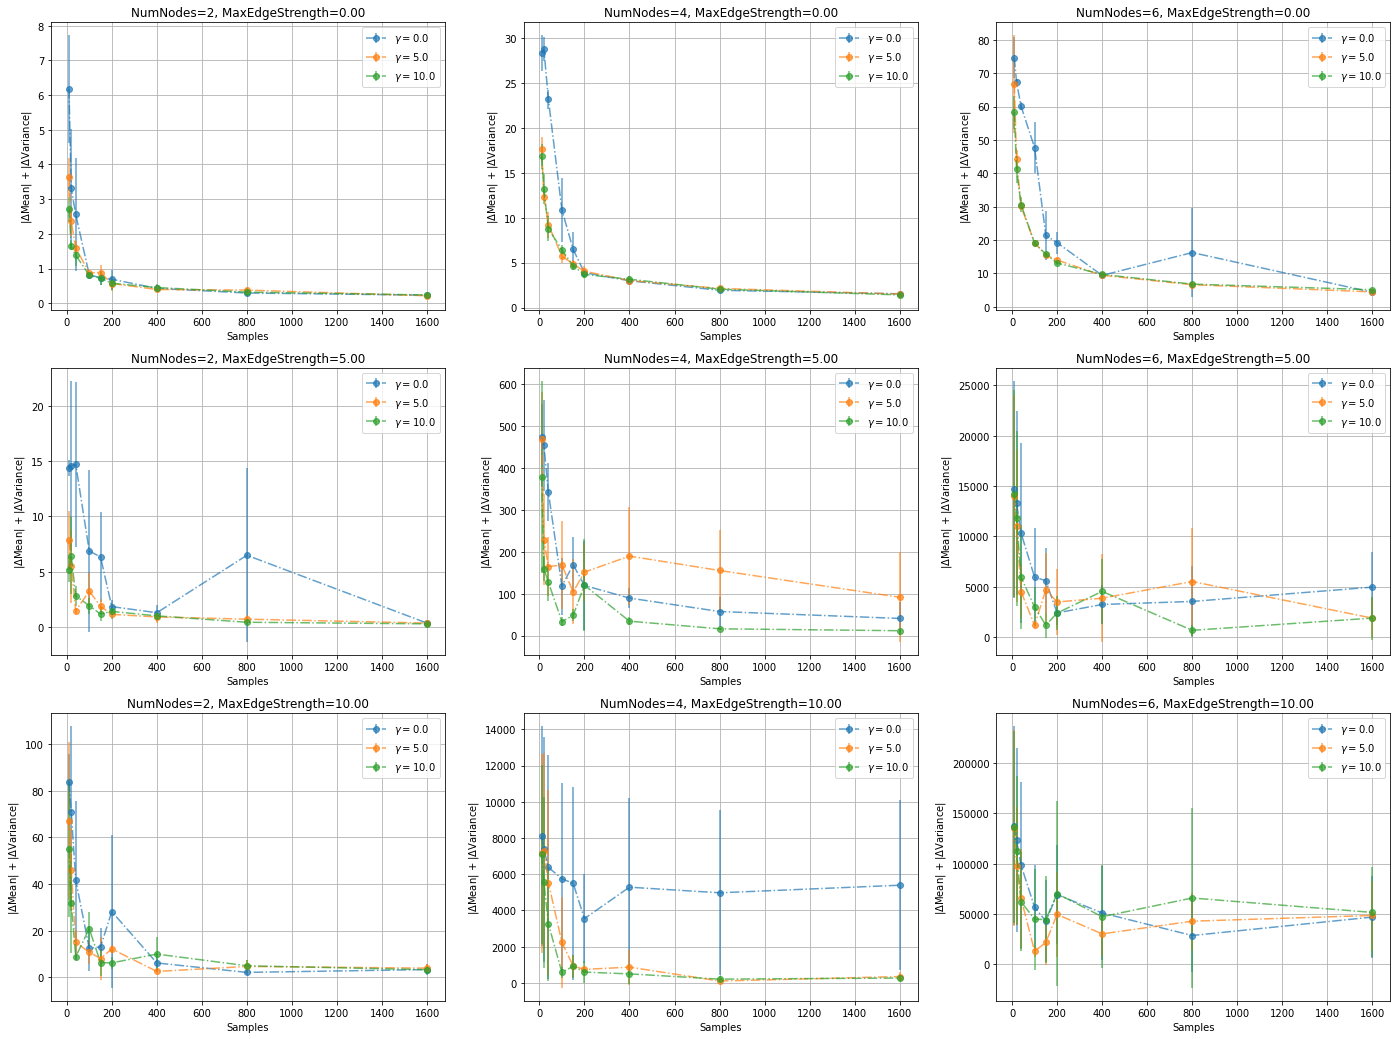

In [116]:
'''
run_list
alpha_list
sample_list
new_noise_mean_list
'''

#Consolidating the errors into into one plot
plt.rcParams['figure.figsize'] = [24, 6*len(alpha_list)]
fig,ax = plt.subplots(nrows=len(alpha_list),ncols=len(node_list))
sample_list=[10,20,40,100,150,200,400,800,1600,3200,6400]
sample_list = sample_list[0:-2]

for nidx,num_nodes in enumerate(node_list):
    all_run_dict = all_node_run_dict[num_nodes]
    for aidx,alpha in enumerate(all_run_dict[run_list[0]].keys()):
        for mean in all_run_dict[run_list[0]][alpha].keys():
            #Getting the average for all the runs
            all_run_mat = []
            for ridx in run_list:
                all_run_mat.append(all_run_dict[ridx][alpha][mean])
            #Getting the mean and variance
            all_run_mat = np.array(all_run_mat)[:,0:len(sample_list)]
            alpha_mean_error_mean = np.mean(all_run_mat,axis=0)
            alpha_mean_error_std = np.std(all_run_mat,axis=0)

            #Now we will plot for this config
            ax[aidx,nidx].errorbar(sample_list,alpha_mean_error_mean,alpha_mean_error_std,label="$\gamma=${}".format(mean),ls="-.",marker="o",alpha=0.7)
    #         ax[aidx].fill_between(sample_list,
    #                               alpha_mean_error_mean-alpha_mean_error_std,
    #                               alpha_mean_error_mean+alpha_mean_error_std,
    #                               alpha=0.1
    #                              )
        ax[aidx,nidx].set_xlabel("Samples")
        ax[aidx,nidx].set_ylabel("|$\Delta$Mean| + |$\Delta$Variance|")
        ax[aidx,nidx].grid()
        ax[aidx,nidx].legend()
        ax[aidx,nidx].set_title("NumNodes={}, MaxEdgeStrength={}".format(str(num_nodes),str(alpha)))
fig.savefig('all_nodes_combined.png'.format(num_nodes), dpi=fig.dpi)